# Analysis Of Road Traffic Accidents occurence in the United Kingdom in the year 2019

This is a project on the analysis and model building from the road traffic accident occurence in the United Kingdom 2019.
It whole data comprises of three datasets.
- **Accident dataset** which comprises of features relating to conditions that lead to the accidents, location and time of accident, with accident Identifier.
- **Vehicle dataset** This contains features about the vehicle involved in the accidents
- **Casualties dataset** It comprises of features relating to casualties of the accident.

In [1]:
#Importing the required libraries
import numpy as np #for linear algebra/data preprocessing
import pandas as pd #for data preprocessing
import matplotlib.pyplot as plt #For visualization
plt.style.use("fivethirtyeight")#For styling the plots
import seaborn as sns #for visualization
import datetime
import warnings
warnings.filterwarnings('ignore')
import math

In [2]:
from sklearn.cluster import KMeans #For clustering
from scipy.stats import mannwhitneyu, shapiro, ttest_ind #For statistical tests
from statsmodels.stats import weightstats as stests #For statistical tests
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler #For Scaling
from sklearn.preprocessing import LabelEncoder, OneHotEncoder #For Encoding
from scipy.spatial.distance import euclidean, cityblock #For distance measurement
import category_encoders as ce #For Encoding
from sklearn.decomposition import PCA #For Principal Components Analysis
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression #To check for feature importance

In [46]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold #To split data
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor# Algorithms for predictions
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor #Algorithms for prediction
from sklearn.linear_model import LinearRegression, LogisticRegression #Algorithms for predictions
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix #For evaluating built models
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.model_selection import cross_val_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
# Load in datasets
Accidents = pd.read_csv('Road Safety Data - Accidents 2019.csv')# Read in the Accidents dataset
casualties = pd.read_csv('Road Safety Data - Casualties 2019.csv')# Read in the casualties dataset
vehicles = pd.read_csv('Road Safety Data- Vehicles 2019.csv')# Read in the vehicles dataset

### Declare functions to be used in the analysis and model building

In [5]:
def Check_missing_percentage(data):
    '''
This function checks for the percentage of missing values in columns of a dataset,It takes dataframes as only parameter. It is implemented using some
python pandas and python object methods, The isnull() method checks for if the column data at that index is missing, which
returns 1 for True and Zero for false, then the .sum() method adds all the 1s together, (/) divides the sum of the 1s by the
total length of the features gotten using the len() function, then the result is multiplied by 100 to get the percentage and
appended to variable (miss), miss is then returned in the function
    '''
    miss = ((data.isnull().sum())/len(data))*100 # Compute the percentage and assign it to a variable
    return miss # Return variable

In [6]:
def Get_summary_stats_category(data, columns):
    '''
    This function is for getting summary statistics of dataframe columns, It takes in the dataframe and relevant columns as 
    parameters, then it uses pandas methods to both get the value_counts and then get columns descriptions using the describe
    method. It then prints out the value counts and returns the summary statistics.
    '''
    stats = data[columns] # Create the stats dataframe
    for i in stats.columns : # Loop through the column
        mode_score = stats[i].mode()[0] # Get the modal score of features
        print(f'modal value for {i} is {mode_score}') # Print the modal score of the feature
        print(f'Unique values for {i} is {stats[i].unique()}') # Print Unique values for the feature
        print(f'The number of unique values for {i} is {stats[i].nunique()}') # Print Number of Unique values for the feture
        print(f' The frequency for {mode_score} is : {stats[i].value_counts()[mode_score]}') # To get the frequency of the modal score
        modal_percent = (stats[i].value_counts()[mode_score]/len(stats[i]) * 100) # To calculate the modal percentage
                         
        print(f'The percentage of the modal score in the distribution is {modal_percent}') # Print the modal percentage
        return stats[i].value_counts().nlargest(10) # return the value_counts for the columns


In [7]:
def fill_missing(data, use_method='ffill', way='dataframe', column=None):
    '''
Function to fill missing values in datasets or individual features, with various methods and ways. It takes in as parameters,
the dataframe, method to be used in filling for missing values, set to ffill by default, ways it should be done,either the
whole dataframe or column wise set to dataframe by default, then column name which was set to none by default.

It uses pandas fillna method for filling for missing values and which takes in methods which are :
ffill = forward fill,  backfill == backward fill, median is using the 50th percentile score to fill it, mean is using the
mean score to fill, and mode is using modal score to fill it. Then setting inplace == True to make it permanent on the
dataframe
    '''
    if way == 'dataframe': # Condition to check way as dataframe
        if use_method == 'ffill': # Condition to check for use method as forward fill
            data.fillna(method='ffill', inplace = True) # forward fill the missing value
            return data.isnull().sum() # Return the sum of missing values
        elif use_method == 'backfill': # Condition to check for use method as backward fill
            data.fillna(method='backfill', inplace = True) # backward fill the missing value
            return data.isnull().sum() # Return the sum of missing values
        else :
            data.fillna(use_method, inplace = True) # use impute to fill the missing value
            return data.isnull().sum() # Return the sum of missing values
    elif way == 'feature': # Condition to check way as feature
        if use_method == 'ffill': # Condition to check for use method as forward fill
            data[column].fillna(method='ffill', inplace = True) # forward fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'backfill': # Condition to check for use method as backward fill
            data[column].fillna(method='backfill', inplace = True) # backward fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'median': # Condition to check for use method as median
            data[column].fillna(data[column].median(), inplace = True) # Use median to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'mean': # Condition to check for use method as mean
            data[column].fillna(data[column].mean(), inplace = True) # Use mean to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        elif use_method == 'mode': # Condition to check for use method as mode
            data[column].fillna(data[column].mode()[0], inplace = True) # Use mode to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        else :
            data[column].fillna(use_method, inplace = True) # use impute to fill the missing value
            return data[column].isnull().sum() # Return the sum of missing values
        

In [8]:
def Fix_outliers(data, feature, method, upper = None, lower = None, impute = None):
    """
Function for fixing outliers using various methods, It takes the dataframe, columns,method for fixing, upper percentile
value none by default,lower percentile value, none by default and impute none by default as parameters. 

There are three methods for fixing in this function :
Imputation = Using another constant value to replace the outlier
Capping = Replacing outliers with the upper and lower percentile values
Log_transform = Getting the logrithm values of the column values and using it to transform the values
    """
    if method.lower() == 'imputation': #Checking condition for imputation
        Q1 = data[feature].quantile(lower) # Storing value for upper limit
        Q3 = data[feature].quantile(upper) # Storing values for lower limit
        print(data[feature].skew()) # Printing the skewness of the feature
        data[feature] = np.where(data[feature] < Q1, impute, data[feature] ) #Replace outliers with an imputted value and assign it to the feature,lower limit
        data[feature] = np.where(data[feature] > Q3, impute, data[feature] )# Replace outlierswith an imputted and assign it to feature, upper limit
        print(df[feature].skew())# Printing the skewness of the feature afterwards
        return data[feature] # Return the fixed feature
    elif method.lower() == 'capping': # Checking condition for capping
        Q1 = data[feature].quantile(lower) #Assign value for lower limit
        Q3 = data[feature].quantile(upper) # Assign value for upper limit
        print(data[feature].skew()) # Print the skewness of the feature
        data[feature] = np.where(data[feature] < Q1, Q1, data[feature] ) #Replace outliers with the lower limit value and assign it to the feature
        data[feature] = np.where(data[feature] > Q3, Q3, data[feature] ) # Replace outliers with the upper limit value and assign it to the feature
        print(data[feature].skew()) # Print the skewness of the feature
        return data[feature] #Return the fixed feature
    elif method.lower() == 'log_transform': # Checking condition for log_transform
        print(data[feature].skew()) #Print skewness of the feature
        data[feature] = np.log(data[feature]) + 1 # Performing the log transformation
        print(data[feature].skew()) # print the skewness after fixing
        return data[feature] # Return the feature

In [9]:
def lets_encode(df, cols, package, encoder = None) :
    """
Function For Encoding Categorical Features, various methods for encoding are included in this function, to choose a
method,
Parameters :
df = Dataframe
cols = column or columns needed
package = method of packages to use which can be : le, ce_oe,oh,du,fe,mt
we provide the following short form of methods with its meaning as follows :
le = Label Encoding
ce_oe = categorical encoders Ordinal Encoding
oh = One hot encoding
du = dummy encoding
fe = frequency encoding
mt = mean target encoding

encoder = external method needed for encoding
    """
    encoded_df = df[cols] #Define dataframe to be encoded
    if package == "le" : # Check for the condition of label encoding
        encoded_df = encoded_df.apply(encoder.fit_transform) # Encode the dataframe
        return encoded_df # return the encoded feature
    elif package == "ce_oe" : # Check for categorical encoding condition
        encoded_df = encoder.fit_transform(encoded_df) # Fit and transform the data using categorical encoding
        return encoded_df # Return encoded feature
    elif package == "oh" : # Check for one hot encoding condition
        encoded_df = pd.DataFrame(encoder.fit_transform(encoded_df).toarray()) # fit and transform features using one hot encoding
        return encoded_df # Return the encoded data
    elif package == "du" : # Check condition for get dummy 
        encoded_df = pd.get_dummies(df[cols]) # Dummy the features
        return encoded_df # Return encoded features
    elif package == 'fe' : # Check for the frequency encoder
        encoded_df = df[cols] # Create a dataframe for the encoder
        y = encoded_df.groupby(cols).size().reset_index() # Groupby the frequency of the values of the features to encode
        y.columns = [cols[0], 'freq'+cols[0]] # Change the column names to the groupby names
        encoded_df = pd.merge(encoded_df,y,on = cols[0], how = 'left') # Merge with dataframe
        return encoded_df # return encoded features
    elif package == "mt" : #Check for mean target encoding
        encoded_df = df[cols] # Create its dataframe
        x = encoded_df.groupby([cols[0]])[cols[1]].sum().reset_index() # Get the feature sum by grouping by the feature and target then getting the sum.
        x = x.rename(columns={cols[1]:cols[0]+"_"+cols[1]+"_sum"})# rename the columns to the grouped columns names

        y = encoded_df.groupby([cols[0]])[cols[1]].count().reset_index()# get feature counts by groupby the column to encode and the target
        y = y.rename(columns={cols[1] :cols[0]+"_"+cols[1]+"_Count"}) # Rename the count columns

        z = pd.merge(x,y,on = cols[0], how = 'inner') # Merge the columns together

        z['Target_enc_levels'] = z[cols[0]+"_"+cols[1]+"_sum"]/z[cols[0]+"_"+cols[1]+"_Count"] # Create a new feature by geting the mean 
        encoded_df = pd.merge(encoded_df,z,on = cols[0], how = 'left') # Merge it with the dataframe

        return encoded_df # Return the encoded feature

In [10]:
def Scaler(df, cols, method):
    """
Function for scaling the dataset using varieties of methods, This function takes in the dataframe, columns to scale and the
methods to use for scaling them, processes and returns a scaled data
The methods are :
mmx == Minmax Scaler
sts == Standard Scaler
rbs == Robust Scaler
    """
    scaled_df = df[cols] # Create a dataframe to scale
    if method.lower() == "mmx": # Check for minmax scaling condition
        scaler = MinMaxScaler() # Define the scaler
        scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df)) # Fit and transform data with the scaler
        scaled_df.columns = cols # Assign column names to the scaled columns
        return scaled_df # Return scaled data
    elif method.lower() == "sts": # Check for standard scaler condition
        scaler = StandardScaler() # Define the scaler
        scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df)) # Fit and transform the data using the scaler
        scaled_df.columns = cols # Assign column names to the scaled data
        return scaled_df# Return the dataframe
    elif method.lower() == "rbs": # Check condition for robust scaler
        scaler = RobustScaler() # Define the scaler
        scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df))# fit and transform the data using the scaler
        scaled_df.columns = cols # Assign column names to the dataframe
        return scaled_df # Return dataframe

In [11]:
def Get_summary_stats_Numerical(data, columns) :
    """
Function to analyse features without using graphs, it takes dataframe as the parameter and uses pandas methods to perform the
EDA.
    """
    stats = data[columns] # Create the stats dataframe
    for i in stats.columns : # Loop through columns
        print(f'column {i} has {stats[i].nunique()} Unique Values') # Print the unique values in features
        print(stats[i].value_counts().nlargest(10))# print the value_counts of the features
        print(f' The mean of the frequency of {i} is : {stats[i].value_counts().mean()}')# print the mean of value_counts of the features
        mode_score = stats[i].mode()[0] # Get the modal score of features
        print(f'modal value for {i} is {mode_score}') # Print the modal score of the feature
        print(f' The frequency for {mode_score} is : {stats[i].value_counts()[mode_score]}') # To get the frequency of the modal score
        modal_percent = (stats[i].value_counts()[mode_score]/len(stats[i]) * 100) # To calculate the modal percentage
        print(f'The percentage of the modal score in the distribution is {modal_percent}') # Print the modal percentage
        mode_score = stats[i].mode()[0] # Get the modal score of features
        print(stats[i].describe())# Print thre summary statistics of the features using describe method
        print('_________________________________________') #print demacation.

In [12]:
def Convert(data, feature, classes) :
    """
Function for changing values in features, It takes data, feature and class to change and change to
    """
    for k,v in classes.items() : # loop through the dictionary
        data[feature].replace(k,v,inplace=True) # Do the replacement
    return data[feature] # Return the features

In [13]:
def Tests_numerical(data, feature, test) :
    """
Function for performing Statistical tests in our datasets, It takes dataframe, columns and test as to specify the tests been performed
There are four tests considered in this function, these are :
ttest == students ttest for testing for two data
shapiro == for test the distribution of the data feature if it is normally distributed or not
mannwhiteny == mannwhitenyu for testing effect of a data over the other
ztest == test for data of two different normally distribet data feature

    """
    if test.lower() == 'ttest' : # Check condition for ttest
        ttest_test,pval = ttest_ind(data[0][feature],data[1][feature]) # Apply ttest to the data feature
        print("p-value for ttest significance is: ", pval) # print the p-value
        if pval <0.05: # Condition for p_values 
            return "we reject null hypothesis for ttest" # if the value less than the threshold P_value
        else: 
            return "we accept null hypothesis for ttest" # if the  P_value is greater than threshold P_value
    elif test.lower() == 'shapiro': # Condition for shapiro
        shapiro_test,pval = shapiro(data[feature]) # Apply shapiro to the data feature
        print("p-value for significance is: ", pval)# print the p-value
        if pval <0.05:
            return "we reject null hypothesis for shapiro"# if the value less than the threshold P_value
        else:
            return "we accept null hypothesis for shapiro"# if the  P_value is greater than threshold P_value
    elif test.lower() == 'mannwhitneyu': # Condition for mannwhitneyu
        mannwhitneyu_test,pval = mannwhitneyu(data[0][feature],data[1][feature])# Apply manwhitneyu to the data feature
        print("p-value for mannwhitneyu significance is: ", pval) # print the p-value 
        if pval <0.05:
            return "we reject null hypothesis for mannwhitneyu" # if the value less than the threshold P_value
        else:
            return "we accept null hypothesis for mannwhitneyu" # if the  P_value is greater than threshold P_value
    elif test.lower() == 'ztest':# Condition for ztest
        ztest_test ,pval = stests.ztest(data[0][feature], x2=data[1][feature], value=0,alternative='two-sided')# Apply z_score to the data feature
        print("p-value for ztest significance is: ", pval) # print the p-value 
        if pval<0.05:
            return "reject null hypothesis for ztest" # if the value less than the threshold P_value
        else:
            return "accept null hypothesis for ztest" # if the  P_value is greater than threshold P_value
    else :
        return "The test you chose if not available" # Check for wrong choice

In [14]:
def Join_two_dummied(data:pd.DataFrame, feature:list, prefix:list,df_name:list, new_data:str):
    """
    The function is to join two dummied features together, it takes as parameter, data, feature list, prefix list, df_name list
    and new data.
    """
    df_name[0] = pd.get_dummies(data[feature[0]],prefix=prefix[0])
    df_name[1] = pd.get_dummies(data[feature[1]],prefix=prefix[1])
    new_data = df_name[0].join(df_name[1])
    return new_data

In [15]:
def Cluster(data, init, n_cluster, n_init, max_iter, random_state ) :
    """
Function for performing KMeans cluster, a clustering algorithm in Machine Learning, cluster algorithms using distance measures
It takes parameters as dataframe, initial value, number of clusters to form, number of initial values, maximum iterations,
random state
    """
    print(data.isnull().sum()) # Check for its missing values
    kmeans = KMeans(init = init, n_clusters = n_cluster, n_init = n_init, max_iter = max_iter, random_state = random_state) #Initialize kmean clustering
    kmeans.fit(data) # Fit data into the initialised dataframe
    return kmeans.labels_ # Return label results

In [16]:
def Elbow_method(data, n, init, n_init, max_iter, random_state):
    """
Fuction to implement a Method to determine the optimal value of number of clusters in KMeans clustering, It takes in dataframe,
number of clusters, initial_value, number of intialized, maximum iteration and random values
    """
    kmeans_kwargs ={
        'init': init,
        'n_init': n_init,
        'max_iter': max_iter,
        'random_state': random_state
    } # Initialise Kmeans algorithm
    sse = [] # empty list to store number of K
    for i in range(1,n): # loop through n 
        kmeans = KMeans(n_clusters=i, **kmeans_kwargs) # Initialize Kmeans
        kmeans.fit(data)# fit in the data
        sse.append(kmeans.inertia_) #append the number of inertia
    plt.style.use("fivethirtyeight") # Plotting style
    plt.plot(range(1,n),sse) # plot graph
    plt.xticks(range(1,n)) # x axis range
    plt.xlabel("Number of Clusters")  # Label x axis
    plt.ylabel("SSE") # Label y axis
    plt.show() # show plot

In [17]:
def PrincipalCA(data, n_components, columns):
    """
Function to perform the Principal Component analysis on the dataframe, A feature engineering technique that uses distance
to get component from data, and take care of overlaping by creating a distance. Parameters are, dataframe, amount of component 
columns to be derived and the initial columns names
    """
    pca = PCA(n_components=n_components) # Initializing PCA
    principalComponents = pca.fit_transform(data) # Fit and transform data using the initialised PCA
    principalDf = pd.DataFrame(data= principalComponents,columns = columns) # Convert the transformed data to a dataset
    return principalDf # Return transformed dataframe

In [47]:
def Apriori_association(data, min_support, min_threshold, metric):
    """
    This function is for deducing association rules by implementing apriori algorithm, It takes in data, minimum support,
    minimum threshold and metrics as parameters
    """
    frequent_set = apriori(data, min_support= min_support, use_colnames=True)
    rules = association_rules(frequent_set, metric=metric,min_threshold=min_threshold)
    return rules

In [19]:
def Kbest_select(data, cols, target, score_func, k):
    """
    Function for performing feature importance for feature extraction, The parameters are dataframe, feature columns, target
    column, function to score with, and number of columns to use
    """
    frame = data.filter(cols, axis=1)# filter only necessary columns from the dataframe and assign it to the variable
    X = frame.drop(target, axis= 1) # create features dataframe by droping the target from the dataframe
    y= frame[target] # Create the target series
    best_features = SelectKBest(score_func= score_func, k= k) # Initialize the algorithm
    fit = best_features.fit(X,y) # Fit the algorithm
    df_scores = pd.DataFrame(fit.scores_) # Convert scores to a dataframe
    df_columns = pd.DataFrame(X.columns) # Convert column names to dataframe
    feature_scores = pd.concat([df_columns,df_scores],axis=1) # Concatenate dataframes together
    feature_scores.columns = ['features','scores'] # Rename column names
    return feature_scores # Return the dataframe

In [20]:
def Class_train_test_split(features, label, random_state, test_size, stratify, split_var):
    """
    This is a function to split the dataframe into train and test data, it takes features, label, random_state, test_size
    stratify, and variable to store splited data as parameters.
    """
    split_var[0],split_var[1],split_var[2],split_var[3] = train_test_split(features,label,random_state=random_state,test_size=test_size, stratify=stratify) # Split data and assign to variables
    print(split_var[0].shape) # Print shape for train features
    print(split_var[1].shape) # Print shape for test features
    print(split_var[2].shape)# Print shape for train labels
    print(split_var[3].shape) # Print shape for test labels
    return split_var # Return variables for splitted data

In [21]:
def Reg_train_test_split(features, label, random_state, test_size, split_var):
    """
    This is a function to split the dataframe into train and test data, it takes features, label, random_state, test_size,
    and variable to store splited data as parameters.
    """
    split_var[0],split_var[1],split_var[2],split_var[3] = train_test_split(features,label,random_state=random_state,test_size=test_size) # Split data and assign to variables
    print(split_var[0].shape)# Print shape for train features
    print(split_var[1].shape)# Print shape for test features
    print(split_var[2].shape)# Print shape for train labels
    print(split_var[3].shape)# Print shape for test labels
    return split_var # Return variables for splitted data

In [22]:
def models_regression(train_features, train_label, test_features, test_label, model_list,predicted_list):
    """
    Function to build four regression models using four different algorithms and output their metrics, it takes train_features,
    train_label, test_features, test_label, List of models variable and list of predicted variables
    """
    model_list[0]= LinearRegression() # Create an object of linear regression
    model_list[0].fit(train_features,train_label) # Fit train data to the object
    predicted_list[0] = model_list[0].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'RMSE score for LinearRegession is :{np.sqrt(mean_squared_error(test_label,predicted_list[0]))}') # Evaluate the model using RMSE score
    print(f'r2_score score for LinearRegession is :{r2_score(test_label,predicted_list[0])}') # Evaluate the model using  r2_score
    print('_________________________________________________________') # Create a demacation line
    model_list[1]= KNeighborsRegressor() # Create an object of KNeighbours Regressor
    model_list[1].fit(train_features,train_label) # Fit train data to the object
    predicted_list[1] = model_list[1].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'RMSE score for KNeighborsRegressor is :{np.sqrt(mean_squared_error(test_label,predicted_list[1]))}') # Evaluate the model using RMSE score
    print(f'r2_score score for KNeighboursRegressor is :{r2_score(test_label,predicted_list[1])}') # Evaluate the model using  r2_score
    print('_________________________________________________________') # Create a demacation line
    model_list[2]= RandomForestRegressor() # Create an object of RandomForest Regressor
    model_list[2].fit(train_features,train_label)# Fit train data to the object
    predicted_list[2] = model_list[2].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'RMSE score for RandomForestRegressor is :{np.sqrt(mean_squared_error(test_label,predicted_list[2]))}') # Evaluate the model using RMSE score
    print(f'r2_score score for RandomForestRegressor is :{r2_score(test_label,predicted_list[2])}') # Evaluate the model using  r2_score
    print('_________________________________________________________') # Create a demacation line
    model_list[3]= GradientBoostingRegressor() # Create an object of GradientBoosting Regressor
    model_list[3].fit(train_features,train_label) # Fit train data to the object
    predicted_list[3] = model_list[3].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'RMSE score for GradientBoostingRegressor is :{np.sqrt(mean_squared_error(test_label,predicted_list[3]))}') # Evaluate the model using RMSE score
    print(f'r2_score score for GradientBoostingRegressor is :{r2_score(test_label,predicted_list[3])}') # Evaluate the model using  r2_score
    print('_________________________________________________________') # Create a demacation line

In [23]:
 def model_classifier(train_features, train_label, test_features, test_label, model_list,predicted_list,type_ave = 'weighted' ):
    """
    Function to build four classification models using four different algorithms and output their metrics.
    It takes train_features, train_label, test_features, test_label,List of model variables, list of predicted variables.
    Average type for F1 score
    """
    model_list[0]= LogisticRegression() # Create an object of logistic regression
    model_list[0].fit(train_features,train_label) # Fit train data to the object
    predicted_list[0] = model_list[0].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for LogisticRegession is :{accuracy_score(test_label,predicted_list[0])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for LogisticRegession is :{f1_score(test_label,predicted_list[0],average = type_ave)}') # Evaluate the model with f1_score
    print(f'Accuracy score for LogisticRegession is :{confusion_matrix(test_label,predicted_list[0])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[0])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[1]= KNeighborsClassifier() # Create an object of KNeighbors Classifier
    model_list[1].fit(train_features,train_label) # Fit train data to the object
    predicted_list[1] = model_list[1].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for KNeighboursClassifier is :{accuracy_score(test_label,predicted_list[1])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for KNeighboursClassifier is :{f1_score(test_label,predicted_list[1],average =type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for KNeighboursClassifier is :{confusion_matrix(test_label,predicted_list[1])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[1])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[2]= RandomForestClassifier() # Create an object of RandomForest Classifier
    model_list[2].fit(train_features,train_label) # Fit train data to the object
    predicted_list[2] = model_list[2].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for RandomForestClassifier is :{accuracy_score(test_label,predicted_list[2])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for RandomForestClassifier is :{f1_score(test_label,predicted_list[2],average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion_matrix for RandomForestClassifier is :{confusion_matrix(test_label,predicted_list[2])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[2])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line
    model_list[3]= GradientBoostingClassifier() # Create an object of GradientBoosting Classifier
    model_list[3].fit(train_features,train_label) # Fit train data to the object
    predicted_list[3] = model_list[3].predict(test_features) # Use the trained object to predict test labels using the test features
    print(f'Accuracy score for GradientBoosting Classifier is :{accuracy_score(test_label,predicted_list[3])}') # Evaluate the model with accuracy_score
    print(f'F1_score score for GradientBoosting Classifier is :{f1_score(test_label,predicted_list[3], average= type_ave)}') # Evaluate the model with f1_score
    print(f'Confusion Matrix for GradientBoosting Classifier is :{confusion_matrix(test_label,predicted_list[3])}') # Evaluate the model with confusion_matrix
    print(classification_report(test_label,predicted_list[3])) # Evaluate the model with classification report
    print('_________________________________________________________') # Create a demacation line

In [24]:
 def Cross_val_classifier(X, y, n_splits, n_repeats, model_list):
    """
    Function to build four classification models using four different algorithms and output their metrics.
    It takes train_features, train_label, test_features, test_label,List of model variables, list of predicted variables.
    Average type for F1 score
    """
    model_list[0]= LogisticRegression() # Create an object of logistic regression
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats= n_repeats, random_state=1)
    scores = cross_val_score(model_list[0], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[0]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[1]= KNeighborsClassifier() # Create an object of KNeighbors Classifier
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[1], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[1]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[2]= RandomForestClassifier() # Create an object of RandomForest Classifier
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[2], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[2]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[3]= GradientBoostingClassifier() # Create an object of GradientBoosting Classifier
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[3], X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[3]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line

In [25]:
 def Cross_val_regression(X, y, n_splits, n_repeats, model_list):
    """
    Function to build four classification models using four different algorithms and output their metrics.
    It takes train_features, train_label, test_features, test_label,List of model variables, list of predicted variables.
    Average type for F1 score
    """
    model_list[0]= LinearRegression() # Create an object of logistic regression
    cv = RepeatedKFold(n_splits=n_splits, n_repeats= n_repeats, random_state=1)
    scores = cross_val_score(model_list[0], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[0]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[1]= KNeighborsRegressor() # Create an object of KNeighbors Classifier
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[1], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[1]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[2]= RandomForestRegressor() # Create an object of RandomForest Classifier
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[2], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[2]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line
    model_list[3]= GradientBoostingRegressor() # Create an object of GradientBoosting Classifier
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    scores = cross_val_score(model_list[3], X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print(f'scores for {model_list[3]} is {np.mean(scores)}')
    print('_________________________________________________________') # Create a demacation line

In [26]:
def Stacking_class(feature:list, target:list, level_0_class:list, level_1_class:str,n_split,stack_method:str,metric:str):
    level_0_classifiers = dict()
    level_0_classifiers['logreg'] = level_0_class[0]
    level_0_classifiers['KNC'] = level_0_class[1]
    level_0_classifiers['RanC'] = level_0_class[2]
    level_0_classifiers['GBC'] = level_0_class[3]
    level_1_classifier = level_1_class
    
    kfold = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=42)
    stacking_model = StackingClassifier(estimators=list(level_0_classifiers.items()),
                                    final_estimator=level_1_classifier, passthrough=False,
                                    cv=kfold, stack_method=stack_method)
    stacking_model.fit_transform(feature[0], target[0])
    class_pred = stacking_model.predict(feature[1])
    print(f' {metric} of scikit-learn stacking classifier: {metric(target[1], class_pred)}')

In [27]:
def Stacking_regr(feature:list, target:list, level_0_class:list, level_1_class:str,n_split,metric:str):
    level_0_classifiers = dict()
    level_0_classifiers['logreg'] = level_0_class[0]
    level_0_classifiers['KNC'] = level_0_class[1]
    level_0_classifiers['RanC'] = level_0_class[2]
    level_0_classifiers['GBC'] = level_0_class[3]
    level_1_classifier = level_1_class
    
    kfold = KFold(n_splits=n_split, shuffle=True, random_state=42)
    stacking_model = StackingRegressor(estimators=list(level_0_classifiers.items()),
                                    final_estimator=level_1_classifier, passthrough=False,
                                    cv=kfold)
    stacking_model.fit_transform(feature[0], target[0])
    class_pred = stacking_model.predict(feature[1])
    print(f' {metric} of scikit-learn stacking classifier: {metric(target[1], class_pred)}')

### Data Cleaning
Steps to take in cleaning our data :
- Check the datasets information.
- Check the datasets missing values and fix it.
- Merge datasets, then recheck the information and missing values, then fix it

In [28]:
Accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117536 entries, 0 to 117535
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               117536 non-null  object 
 1   Location_Easting_OSGR                        117508 non-null  float64
 2   Location_Northing_OSGR                       117508 non-null  float64
 3   Longitude                                    117508 non-null  float64
 4   Latitude                                     117508 non-null  float64
 5   Police_Force                                 117536 non-null  int64  
 6   Accident_Severity                            117536 non-null  int64  
 7   Number_of_Vehicles                           117536 non-null  int64  
 8   Number_of_Casualties                         117536 non-null  int64  
 9   Date                                         117536 non-nul

In [29]:
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216381 entries, 0 to 216380
Data columns (total 23 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   Accident_Index                    216381 non-null  object
 1   Vehicle_Reference                 216381 non-null  int64 
 2   Vehicle_Type                      216381 non-null  int64 
 3   Towing_and_Articulation           216381 non-null  int64 
 4   Vehicle_Manoeuvre                 216381 non-null  int64 
 5   Vehicle_Location-Restricted_Lane  216381 non-null  int64 
 6   Junction_Location                 216381 non-null  int64 
 7   Skidding_and_Overturning          216381 non-null  int64 
 8   Hit_Object_in_Carriageway         216381 non-null  int64 
 9   Vehicle_Leaving_Carriageway       216381 non-null  int64 
 10  Hit_Object_off_Carriageway        216381 non-null  int64 
 11  1st_Point_of_Impact               216381 non-null  int64 
 12  Wa

Considering Information from the datasets we can deduce that three have just one common feature which is Accident_Index. While vehicle and casualties datasets have Vehicle_Reference as common features. 

In [30]:
#Check missing values.
Check_missing_percentage(Accidents)


Accident_Index                                 0.000000
Location_Easting_OSGR                          0.023822
Location_Northing_OSGR                         0.023822
Longitude                                      0.023822
Latitude                                       0.023822
Police_Force                                   0.000000
Accident_Severity                              0.000000
Number_of_Vehicles                             0.000000
Number_of_Casualties                           0.000000
Date                                           0.000000
Day_of_Week                                    0.000000
Time                                           0.053601
Local_Authority_(District)                     0.000000
Local_Authority_(Highway)                      0.000000
1st_Road_Class                                 0.000000
1st_Road_Number                                0.000000
Road_Type                                      0.000000
Speed_limit                                    0

In [31]:
Check_missing_percentage(vehicles)

Accident_Index                      0.0
Vehicle_Reference                   0.0
Vehicle_Type                        0.0
Towing_and_Articulation             0.0
Vehicle_Manoeuvre                   0.0
Vehicle_Location-Restricted_Lane    0.0
Junction_Location                   0.0
Skidding_and_Overturning            0.0
Hit_Object_in_Carriageway           0.0
Vehicle_Leaving_Carriageway         0.0
Hit_Object_off_Carriageway          0.0
1st_Point_of_Impact                 0.0
Was_Vehicle_Left_Hand_Drive?        0.0
Journey_Purpose_of_Driver           0.0
Sex_of_Driver                       0.0
Age_of_Driver                       0.0
Age_Band_of_Driver                  0.0
Engine_Capacity_(CC)                0.0
Propulsion_Code                     0.0
Age_of_Vehicle                      0.0
Driver_IMD_Decile                   0.0
Driver_Home_Area_Type               0.0
Vehicle_IMD_Decile                  0.0
dtype: float64

In [32]:
Check_missing_percentage(casualties)

Accident_Index                        0.0
Vehicle_Reference                     0.0
Casualty_Reference                    0.0
Casualty_Class                        0.0
Sex_of_Casualty                       0.0
Age_of_Casualty                       0.0
Age_Band_of_Casualty                  0.0
Casualty_Severity                     0.0
Pedestrian_Location                   0.0
Pedestrian_Movement                   0.0
Car_Passenger                         0.0
Bus_or_Coach_Passenger                0.0
Pedestrian_Road_Maintenance_Worker    0.0
Casualty_Type                         0.0
Casualty_Home_Area_Type               0.0
Casualty_IMD_Decile                   0.0
dtype: float64

Checking missing percentages of the three datasets shows only Accident dataset has features with missing values. And the features with missing values are location and time features. 

Since most of the percentages of missing values of relevant features is less than one percent, filling it using forward fill or backward fill won't have much bad effect on it since it will be duplicating from an existing data, and it won't affect the shape of the data too since it is not much for Location features. forward filling and backward filling is Ideal for time data too. Since these both features needs not be normaly distributed, forward and backward filling is good in retaining the shape of data distribution.

In [33]:
#Filling Missing Values
fill_missing(Accidents)
fill_missing(Accidents, 'backfill')

Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                               0
2nd_Road_Class      

So What forward fill does is fetch the value from the index before the index with missing value and use it to fill the missing value while backward fill fetches from the index after the index with missing values and use that to fill missing values.

So both is applied here incase we have missing value in either the first or the last index.

### Merge the datasets together.

From some of the questions to be answered in this project, There is a need to compare some features which are located in different datasets, This calls for merging datasets together to achieve easier analysis on the data.
A Particular Feature **Accident Index** seems to be present in the three datasets, this creates a better avenue for merging the datasets together. Resulting missing values will be filled to avoid loss of data

In [34]:
#Check Unique values for the common feature
print(Accidents['Accident_Index'].nunique())
print(vehicles['Accident_Index'].nunique())
print(casualties['Accident_Index'].nunique())

117536
117539
117537


This gives an inference that they are having almost the same classes of data in their common feature, which gives avenue to join on that feature

In [35]:
# Merging datasets
casualty_vehicle = pd.merge(vehicles, casualties, on = "Accident_Index", how = "outer") #To merge Casualties and Vehicles datasets together

In [36]:
df = pd.merge(Accidents,casualty_vehicle, on = "Accident_Index", how = "left") #To merge casualty_vehicles and accidents together

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258188 entries, 0 to 258187
Data columns (total 69 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               258188 non-null  object 
 1   Location_Easting_OSGR                        258188 non-null  float64
 2   Location_Northing_OSGR                       258188 non-null  float64
 3   Longitude                                    258188 non-null  float64
 4   Latitude                                     258188 non-null  float64
 5   Police_Force                                 258188 non-null  int64  
 6   Accident_Severity                            258188 non-null  int64  
 7   Number_of_Vehicles                           258188 non-null  int64  
 8   Number_of_Casualties                         258188 non-null  int64  
 9   Date                                         258188 non-nul

In [38]:
df['Accident_Index'].nunique()

117536

In [39]:
Check_missing_percentage(df)

Accident_Index                         0.000000
Location_Easting_OSGR                  0.000000
Location_Northing_OSGR                 0.000000
Longitude                              0.000000
Latitude                               0.000000
                                        ...    
Bus_or_Coach_Passenger                11.106635
Pedestrian_Road_Maintenance_Worker    11.106635
Casualty_Type                         11.106635
Casualty_Home_Area_Type               11.106635
Casualty_IMD_Decile                   11.106635
Length: 69, dtype: float64

To fill for missing values, I am using forward fill and backward fill since the datasets **Accident_Index** columns have almost same unique values.This means that their index will be determined by Accident_Index and each vehicle feature that comes in that accident index will be same for the the casualty features or the vehicle features. 

In [40]:
fill_missing(df) #For forward fill
fill_missing(df, 'backfill') #For backward fill

Accident_Index                        0
Location_Easting_OSGR                 0
Location_Northing_OSGR                0
Longitude                             0
Latitude                              0
                                     ..
Bus_or_Coach_Passenger                0
Pedestrian_Road_Maintenance_Worker    0
Casualty_Type                         0
Casualty_Home_Area_Type               0
Casualty_IMD_Decile                   0
Length: 69, dtype: int64

In [41]:
Check_missing_percentage(df) #Check for missing values

Accident_Index                        0.0
Location_Easting_OSGR                 0.0
Location_Northing_OSGR                0.0
Longitude                             0.0
Latitude                              0.0
                                     ... 
Bus_or_Coach_Passenger                0.0
Pedestrian_Road_Maintenance_Worker    0.0
Casualty_Type                         0.0
Casualty_Home_Area_Type               0.0
Casualty_IMD_Decile                   0.0
Length: 69, dtype: float64

# Exploratory Data Analysis
After having a clean data to an extent, Its time to start analysing the data, and this is where we start answering our project questions

In [42]:
#Copy the dataframe for ease with analysis
Analysis = df.copy() #Created a copy of the dataset to use for analysis

Inorder to effectively analyse features relating to time, I have to convert the data to a date time data type

In [39]:
Analysis['converted_time'] = pd.DatetimeIndex(Analysis['Time']) #Convert to datetime data type

In [40]:
Analysis['Hour'] = Analysis['converted_time'].dt.hour #Generate hour feature from the date_time feature

**Question A plot for the significant hours of the day and days of the week where traffic accidents happens most.**

My approach to this question will be the use of statistics and visualization, will first check the column in question.

In [41]:
Get_summary_stats_category(Analysis, ['Hour']) # Get Summary Statistics of the feature

modal value for Hour is 17
Unique values for Hour is [17 21  1  0  2  4  3  5  7  9 14 15 11 13 16  6 12 18 20 19 23 10 22  8]
The number of unique values for Hour is 24
 The frequency for 17 is : 23211
The percentage of the modal score in the distribution is 8.989960803755404


17    23211
16    21171
15    19837
18    18137
8     16619
14    16090
13    15845
12    15178
19    13700
11    13380
Name: Hour, dtype: int64

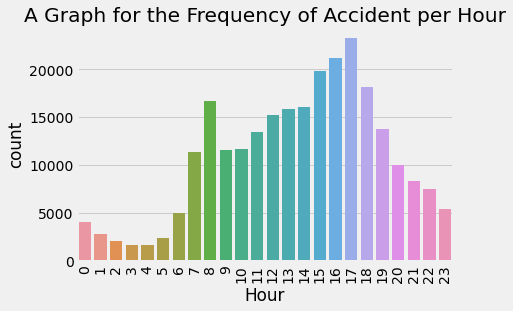

In [42]:
#Countplot to get the modal hour for accident occurence
sns.countplot(data= Analysis, x='Hour')
plt.tick_params(axis='x', rotation=90)
plt.title('A Graph for the Frequency of Accident per Hour')
plt.show()

From the frequency statistics,And basic analysis about the feature in question.

The Hour feature has 24 unique values which is equivalent to the 24 hours that makes a day.

Night averagely spanning through 20:00 hour till 6:00 hour while day spans averagely through 7:00 hour till 19:00 hour.

This can be due to the activities that happens during the day, like school time, most job times and so on.

The modal hour for accidents is 17:00 hour, this averagely is few hours before sunsets.

The modal hour with frequency of 23211 constitutes to 8.99% of the total accident happening in a day.

 Accidents are more frequent at, 08, 15,16,17,18 hours respectively which tends to point to the fact of those hours are rush hours when people rush to work at 08:00 hours and are rushing back home at 15:00 to 18:00 hours respectively.

In [43]:
Get_summary_stats_category(Analysis, ['Day_of_Week'])

modal value for Day_of_Week is 6
Unique values for Day_of_Week is [2 3 4 5 6 7 1]
The number of unique values for Day_of_Week is 7
 The frequency for 6 is : 42017
The percentage of the modal score in the distribution is 16.273800486467223


6    42017
5    38767
4    38374
3    37686
2    35840
7    35407
1    30097
Name: Day_of_Week, dtype: int64

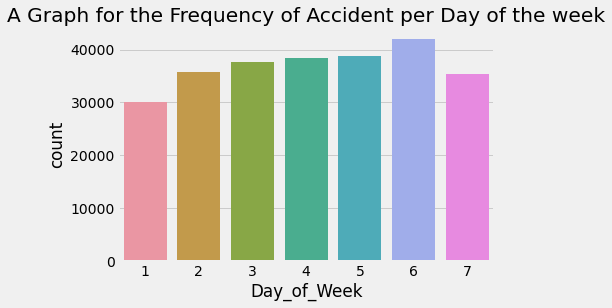

In [44]:
# For days of the week to get modal days for traffic accident
sns.countplot(data= Analysis, x='Day_of_Week')
plt.title('A Graph for the Frequency of Accident per Day of the week')
plt.show()

The Days_of_Week feature with regards to accident occurence :
It has seven unique values that ranges from 1 to 7 equivalent to days in a week respectively, that is from Sunday till Saturday

The modal day involved in road accidents is Friday, equivalent to the the class with value 6 in the feature.

The modal day with a frequency of 42017 constitutes to 16.23% of total accidents happening in the UK per week.
Other Working days frequency from Monday (day 2) till Thursday (day 5) follows in ascending order.

The high value of accidents on Friday is seen to be the mixture of people commuting due to school, work, and other people traveling for the weekends or for parties.

The weekend days Sunday and Monday (day 7 and 1) witnesses relative less accident because there is traffic due to less activities that involves the use of major roads.

**Question B For motorbikes, significant hours of the day and days of the week for accidents to occur.**
Using Frequentist Statistics
**NB** One of the reasons for merging the datasets

In [45]:
# Converting some values from the Vehicle_Type features to Motorcycle
classes = {2:'Motorcycle',3:'Motorcycle',4:'Motorcycle',
          5:'Motorcycle',22:'Motorcycle',23:'Motorcycle',
          97:'Motorcycle'}

In [46]:
#Convert some vehicle types to motorcycle
Analysis['Vehicle_Type'] = Convert(Analysis,'Vehicle_Type',classes)

In [47]:
#Creating a dataframe only for motorcycle Vehicle_Type
Motorcycle = Analysis[Analysis['Vehicle_Type'] == 'Motorcycle']

A dataframe for Motorcycle was Created by filtering through values in Vehicle_Type feature equal to Motorcycle in the Analysis dataframe

In [48]:
Get_summary_stats_category(Motorcycle, ['Hour'])

modal value for Hour is 17
Unique values for Hour is [ 0 14 15 13 16  6 19 18 17 10 12  8  9 21  3 11 20 23  2  7 22  5  1  4]
The number of unique values for Hour is 24
 The frequency for 17 is : 1530
The percentage of the modal score in the distribution is 9.603314084860658


17    1530
16    1378
18    1348
15    1209
13    1066
14    1001
19     991
12     957
8      853
11     749
Name: Hour, dtype: int64

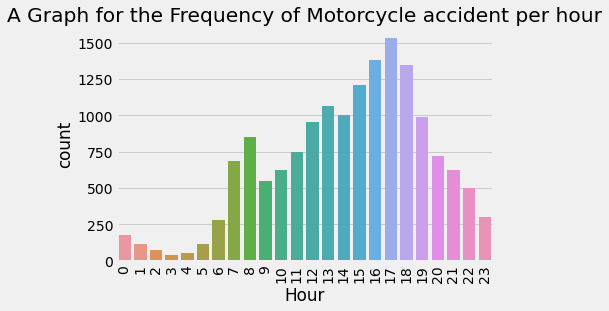

In [49]:
sns.countplot(data= Motorcycle, x='Hour')
plt.tick_params(axis='x', rotation=90)
plt.title('A Graph for the Frequency of Motorcycle accident per hour')
plt.show()

From the frequency statistics,And basic analysis about the feature in question.

The Hour feature has 24 unique values which is equivalent to the 24 hours that makes a day.

Night averagely spanning through 20:00 hour till 6:00 hour while day spans averagely through 7:00 hour till 19:00 hour.

This can be due to the activities that happens during the day, like school time, most job times and so on.

The modal hour for motorcycle accidents is 17:00 hour, this averagely is few hours before sunsets.

The modal hour has a frequency of 1530 which constitutes 9.60% of the total motorcycle accident happening in a day.

 Motorcycle accidents are more frequent at 12,13,14, 15,16,17,18 and 19 hours respectively which tends to point to the fact that most carrier businesses within cities uses motorcycle for transport and rush hours after the days work and school.

In [50]:
Get_summary_stats_category(Motorcycle, ['Day_of_Week'])

modal value for Day_of_Week is 6
Unique values for Day_of_Week is [3 4 5 6 7 1 2]
The number of unique values for Day_of_Week is 7
 The frequency for 6 is : 2570
The percentage of the modal score in the distribution is 16.131056992216923


6    2570
5    2363
4    2358
7    2232
3    2231
1    2119
2    2059
Name: Day_of_Week, dtype: int64

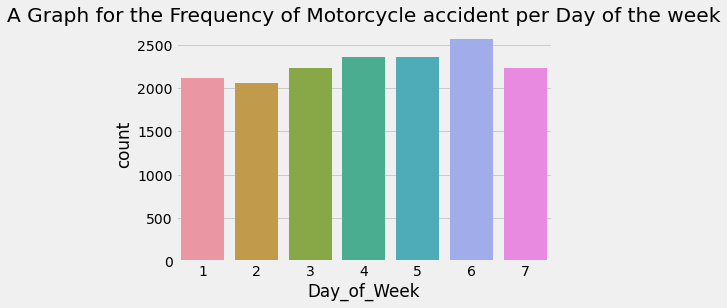

In [51]:

sns.countplot(data= Motorcycle, x='Day_of_Week')
plt.title('A Graph for the Frequency of Motorcycle accident per Day of the week')
plt.show()

The Days_of_Week feature with regards to motorcycle accident occurence :
It has seven unique values that ranges from 1 to 7 equivalent to days in a week respectively, that is from Sunday till Saturday

The modal day involved in road accidents is Friday, equivalent to the the class with value 6 in the feature.

The modal day with a frequency of 4570 constitutes to 16.13% of total accidents happening in the UK per week.

The high value of motorcycle accidents on Friday is seen to be the mixture of people commuting due to school, work, and other people traveling for the weekends or for parties.

The relative rise of motorcycle accidents on weekends compared to total Vehicle_Types is due to the fact that young people and youths who are the largest users of motorcycles ([researchgate][]). Who would rather go to school or work using other means of transportation but use their motorcycles on weekends 


[researchgate]: https://www.researchgate.net/figure/Demographic-motorcycle-and-environmental-sample-characteristics-of-motorcyclists_tbl1_233829000

This is similar to general distributions for overall accident occurence, just that motorcycle accidents seems to occur more frequently relatively to the frequency of other days when we compare the overall days and motorcycle days, and the day with the highest occuring accident is Friday (Day 06) 

**Question C For pedestrians involved in the accident, significant hours of the day and days of the week for the accident.**

Using frequentist Statistics

**NB** Another reason for merging

In [52]:
#Convert Casualty_Class feature to catgorical feature
Analysis['Casualty_Class'].replace(3,'Pedestrian',inplace=True)
Analysis['Casualty_Class'].replace(2,'Passenger',inplace=True)
Analysis['Casualty_Class'].replace(1,'Driver or Rider',inplace=True)

In [53]:

Casualty = {1:'Driver or rider',2:'Passenger',3:'Pedestrian'}

Analysis['Casualty_Class'] = Convert(Analysis,'Casualty_Class', Casualty)

In [54]:
#Create a dataframe whose Casualty_Class feature only has pedestrian as value
Pedestrian = Analysis[Analysis['Casualty_Class'] == 'Pedestrian']

A dataframe for pedestrian was Created by filtering through values in Casualty_Class feature equals to Pedestrian in the Analysis dataframe

In [55]:
Get_summary_stats_category(Pedestrian, ['Hour'])

modal value for Hour is 15
Unique values for Hour is [ 1  3  2  4  5 15 12 23 19 18 17  7 20  8  9 10 13 16 14 11 21 22  0  6]
The number of unique values for Hour is 24
 The frequency for 15 is : 2570
The percentage of the modal score in the distribution is 10.217062892581696


15    2570
17    2178
16    2145
8     2007
18    1799
14    1439
12    1414
13    1395
19    1334
11    1180
Name: Hour, dtype: int64

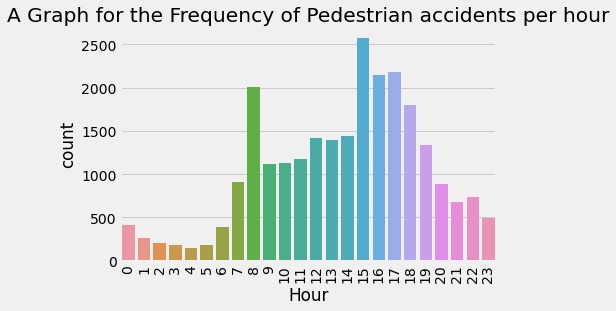

In [56]:
sns.countplot(data= Pedestrian, x='Hour')
plt.tick_params(axis='x', rotation=90)
plt.title('A Graph for the Frequency of Pedestrian accidents per hour')
plt.show()

From the frequency statistics,And basic analysis about the feature in question.

The Pedestrian Hour feature has 24 unique values which is equivalent to the 24 hours that makes a day.

Night averagely spanning through 20:00 hour till 6:00 hour while day spans averagely through 7:00 hour till 19:00 hour.

There is relative higher pedestrian accident occuring during the day than at night times.

This can be due to the activities that happens during the day, like school time, most job times and so on.

The modal hour for pedestrian accidents is 15:00 hour.

The modal hour has a frequency of 2570 which constitutes 10.21% of the total pedestrian accident happening in a day.

 Pedestrian accidents are more frequent at 08,12,13,14, 15,16,17, and 18 hours respectively which tends to point to the fact that, most job and school resumes around that time, most school closes around that time, a peak hour for market activities and rush hours after the days work and school.

This distribution shows a surge at 08:00 hours with respect to other times distributions, most significant hours are from 15:00 hours till 18:00 hours but unlike the general accident hours and motorcycle accident hours whose peak values are 17:00 hours, The one for Pedestrians is 15:00 hours.

In [57]:
Get_summary_stats_category(Pedestrian,['Day_of_Week'])

modal value for Day_of_Week is 6
Unique values for Day_of_Week is [3 4 5 6 7 1 2]
The number of unique values for Day_of_Week is 7
 The frequency for 6 is : 4148
The percentage of the modal score in the distribution is 16.490419018843923


6    4148
5    3961
3    3958
4    3895
2    3553
7    3261
1    2378
Name: Day_of_Week, dtype: int64

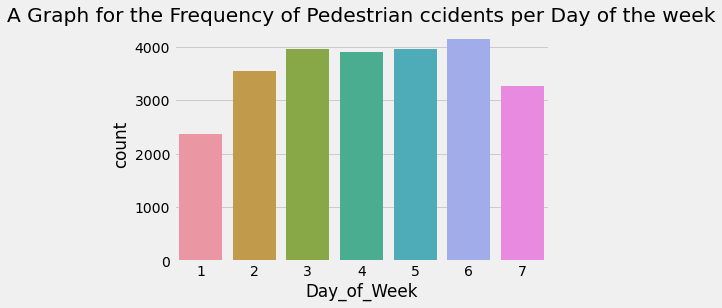

In [58]:
#Plot day for pedestrians
sns.countplot(data= Pedestrian, x='Day_of_Week')
plt.title('A Graph for the Frequency of Pedestrian ccidents per Day of the week')
plt.show()

The Days_of_Week feature with regards to pedestrian accident occurence :
It has seven unique values that ranges from 1 to 7 equivalent to days in a week respectively, that is from Sunday till Saturday

The modal day involved in road pedestrian accidents is Friday, equivalent to the the class with value 6 in the feature.

The modal day with a frequency of 4148 constitutes to 16.49% of total accidents happening in the UK per week.
Other Working days frequency from Monday (day 2) till Thursday (day 5) have closely high frequency.

The high value of accidents on Friday is seen to be the mixture of people commuting due to school, and work.

The weekend days Sunday and Monday (day 7 and 1) witnesses relative less accident because there is traffic due to less activities that involves the use of major roads.

Pedestrian day distribution is like a replica of total day of the week distribution with Friday (day 06) taking the day with the modal frequency.

**Question D	What impact, if any, does daylight savings have on road traffic accidents in the week after it starts and stops**

To answer question d, one will need to extract the week feature from the date feature.

In [59]:
#Converting the date feature to a date_time data type feature.
Analysis['Date'] = pd.to_datetime(Analysis['Date'])

In [60]:
#Extracting week feature from the date date_time feature
Analysis['week'] = Analysis['Date'].dt.week + Analysis['Date'].dt.day/7

To answer question **D**,  The daylight saving day starts from 31st of March 2019, equivalent to week 12.71 in 2019 and stops on the 27th day of October 2019, equivalent to week 42.71 of 2019.

In [61]:
Get_summary_stats_Numerical(Analysis, ['week'])

column week has 251 Unique Values
22.285714    2352
35.142857    2284
44.285714    2230
48.142857    2133
5.428571     2096
9.142857     2083
5.285714     2037
22.142857    1921
7.142857     1727
28.000000    1726
Name: week, dtype: int64
 The mean of the frequency of week is : 1028.6374501992032
modal value for week is 22.285714285714285
 The frequency for 22.285714285714285 is : 2352
The percentage of the modal score in the distribution is 0.9109641036763908
count    258188.000000
mean         28.739239
std          15.036263
min           1.142857
25%          16.285714
50%          29.142857
75%          42.000000
max          56.142857
Name: week, dtype: float64
_________________________________________


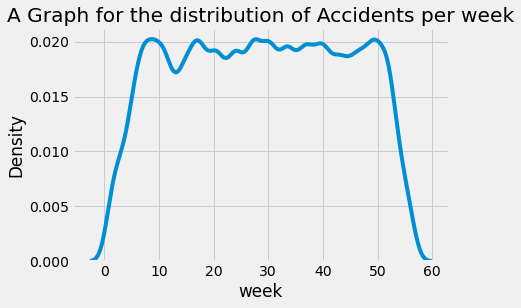

In [62]:
# Plotting for the distribution of the total weeks
sns.kdeplot(data= Analysis, x ='week')
plt.title('A Graph for the distribution of Accidents per week')
plt.show()

This distribution shows less of a normal distribution. But for our analysis to come, I will use statistical testings to ascertain my observations. Peak values are over 8000 while least values are below 500.

Visualization Shows though not clearly that accident reduces the immediate week after day light savings starts and stops.
But to prove it better, there is need for statistical hypothesis tests

In [63]:
#Create dataframes for a week after daylight savings starts, then another dataframe for the rest of the weeks
Savings = Analysis[(Analysis['week'] > 12.71) & (Analysis['week'] <= 13.71)]
rest_savings = Analysis[(Analysis['week'] <= 12.71) | (Analysis['week'] > 13.71)]

The daylight savings for 2019 was gotten from(([time and date.com][]) as 31st of March 2019) which was mathematical calculated by adding months from January 1st till March 31st and dividing the answer by 7 which gives 12.71, then adding a week after gives 13.71. 

So from there, I created dataframes for first week of Daylight savings and the rest of the weeks

[time and date.com]: https://www.timeanddate.com/time/change/uk/london?year=2019

In [64]:
Get_summary_stats_Numerical(Savings, ['week'])

column week has 7 Unique Values
12.857143    1376
13.000000    1326
12.714286     829
12.714286     745
13.142857     707
13.428571     566
13.285714     562
Name: week, dtype: int64
 The mean of the frequency of week is : 873.0
modal value for week is 12.857142857142858
 The frequency for 12.857142857142858 is : 1376
The percentage of the modal score in the distribution is 22.51677303223695
count    6111.000000
mean       12.976740
std         0.227967
min        12.714286
25%        12.714286
50%        13.000000
75%        13.142857
max        13.428571
Name: week, dtype: float64
_________________________________________


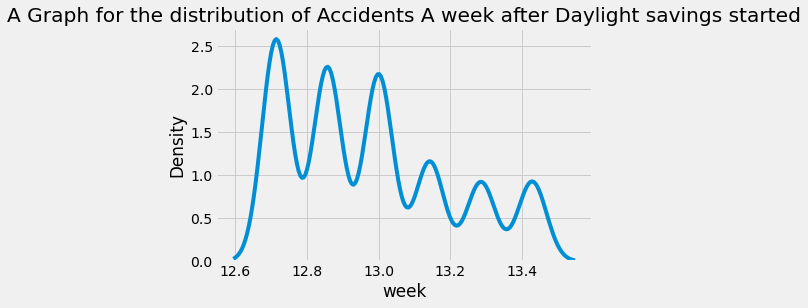

In [65]:
sns.kdeplot(data= Savings, x='week')
plt.title('A Graph for the distribution of Accidents A week after Daylight savings started')
plt.show()

In [66]:
Get_summary_stats_Numerical(rest_savings, ['week'])

column week has 244 Unique Values
22.285714    2352
35.142857    2284
44.285714    2230
48.142857    2133
5.428571     2096
9.142857     2083
5.285714     2037
22.142857    1921
7.142857     1727
28.000000    1726
Name: week, dtype: int64
 The mean of the frequency of week is : 1033.1024590163934
modal value for week is 22.285714285714285
 The frequency for 22.285714285714285 is : 2352
The percentage of the modal score in the distribution is 0.9330482352614479
count    252077.000000
mean         29.121363
std          15.013317
min           1.142857
25%          16.857143
50%          29.571429
75%          42.285714
max          56.142857
Name: week, dtype: float64
_________________________________________


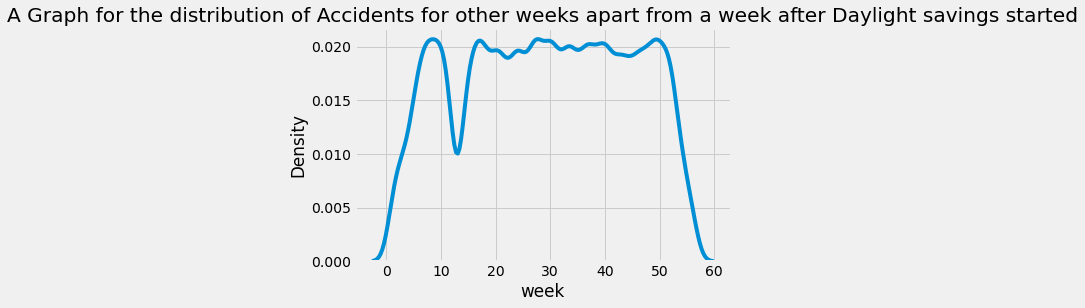

In [67]:
sns.kdeplot(data= rest_savings, x='week')
plt.title('A Graph for the distribution of Accidents for other weeks apart from a week after Daylight savings started')
plt.show()

Distributions for both plots on daylight savings are not normally distributed. I will use statistical tests to prove my observations ([britannica][])

[britannica]: https://www.britannica.com/topic/normal-distribution

In these statistical tests, p-value was set to 5% confidence, so if the confidence is greater then or equal to 5%, then the null hypothesis is accepted. which translates that there is no special effect in what we are performing the test on.

While Rejected Null hypothesis indicates something special in the comparison

In [68]:
#Test for normal distribution for the week after daylight savings starts
Tests_numerical(Savings,'week','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [69]:
#Test for normal distribution for other weeks apart from the week after
Tests_numerical(rest_savings,'week','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [70]:
#Test for effect a week after the start of daylight savings
Tests_numerical([Savings,rest_savings],'week','mannwhitneyu')

p-value for mannwhitneyu significance is:  0.0


'we reject null hypothesis for mannwhitneyu'

Comparing both dataframe's statistics, We first had the statistics which indicate the the frequency for the week with highest accident occurence is, and Using hypothesis testing to test both for the the shape of the data and probability value of its randomness.

A decline can be seen in the graph's distribution and modal value frequency

The frequency for the modal value for a week after daylight savings started is 1376 against the frequency of the modal value for the rest of the weeks which is 2352

While the mean of their frequency is 873 and 1033.1 respectively both for when daylight savings started and the rest of weeks.

These all confirms the decline in accident frequency after daylight savings started.

The Use of Statistical tests

Shapiro test was used to test for shape while mannwhitneyu test was used to test for the confidence of the probability of it been random since it is not a Gaussian distributed data.

The P_value for Shapiro test is less than 0.05, this shows that the data is not Gaussian distributed


The P_value from mannwhitneyu test is less than 0.05, which means the Assumption that the that frequency of accident reduced the first week after the daylight savings started is true.

In [71]:
#Create dataframes for a week after daylight saving ends and other weeks
not_savings = Analysis[(Analysis['week'] > 42.71) & (Analysis['week'] <= 43.71)]
rest_not_savings = Analysis[(Analysis['week'] <= 42.71) | (Analysis['week'] > 43.71)]

The daylight savings for 2019 was gotten from(([time and date.com][]) as 27th October 2019) which was mathematical converted by adding days of months from January 1st till 27th October and dividing the answer by 7 which gives 42.71, then adding a week after gives 43.71. 

So from there, I created dataframes for first week of daylight_not_savings and the rest of the weeks

[time and date.com]: https://www.timeanddate.com/time/change/uk/london?year=2019

In [72]:
Get_summary_stats_Numerical(not_savings, ['week'])

column week has 4 Unique Values
42.714286    1430
42.857143    1382
43.142857     670
43.000000     652
Name: week, dtype: int64
 The mean of the frequency of week is : 1033.5
modal value for week is 42.714285714285715
 The frequency for 42.714285714285715 is : 1430
The percentage of the modal score in the distribution is 34.59119496855346
count    4134.000000
mean       42.876564
std         0.152108
min        42.714286
25%        42.714286
50%        42.857143
75%        43.000000
max        43.142857
Name: week, dtype: float64
_________________________________________


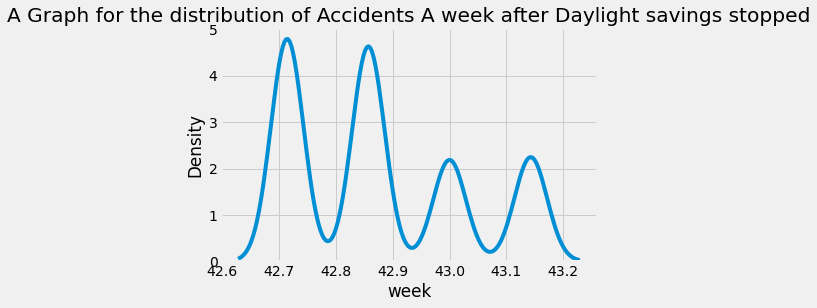

In [73]:
sns.kdeplot(data= not_savings, x='week')
plt.title('A Graph for the distribution of Accidents A week after Daylight savings stopped')
plt.show()

In [74]:
Get_summary_stats_Numerical(rest_not_savings, ['week'])

column week has 247 Unique Values
22.285714    2352
35.142857    2284
44.285714    2230
48.142857    2133
5.428571     2096
9.142857     2083
5.285714     2037
22.142857    1921
7.142857     1727
28.000000    1726
Name: week, dtype: int64
 The mean of the frequency of week is : 1028.5587044534414
modal value for week is 22.285714285714285
 The frequency for 22.285714285714285 is : 2352
The percentage of the modal score in the distribution is 0.9257874310186024
count    254054.000000
mean         28.509195
std          15.048676
min           1.142857
25%          15.428571
50%          28.000000
75%          40.714286
max          56.142857
Name: week, dtype: float64
_________________________________________


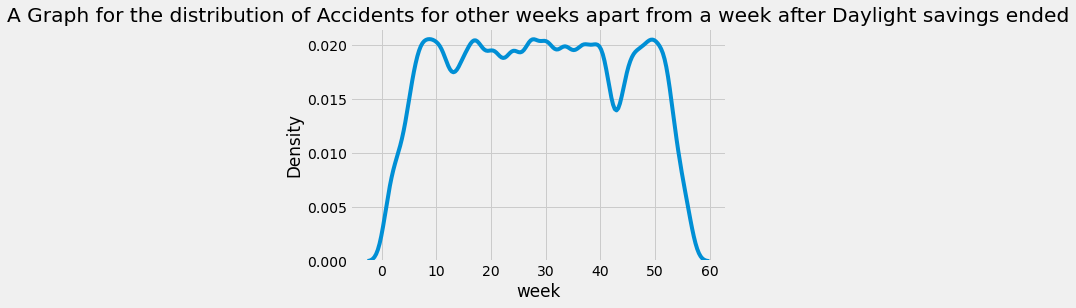

In [75]:
sns.kdeplot(data= rest_not_savings, x='week')
plt.title('A Graph for the distribution of Accidents for other weeks apart from a week after Daylight savings ended')
plt.show()

In [76]:
#Test for normal distribution for the week after daylight savings stops
Tests_numerical(not_savings,'week','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [77]:
#Test for normal distribution for other weeks apart from the week after it stops
Tests_numerical(rest_not_savings,'week','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [78]:
#Test for effect a week after the stops of daylight savings
Tests_numerical([not_savings,rest_not_savings],'week','mannwhitneyu')

p-value for mannwhitneyu significance is:  0.0


'we reject null hypothesis for mannwhitneyu'

Comparing both dataframe's statistics, We first had the statistics which indicate the the frequency for the week with highest accident occurence is, and Using hypothesis testing to test both for the the shape of the data and probability value of its randomness.

A decline can be seen in the graph's distribution and modal value frequency

The frequency for the modal value for a week after daylight savings ended is 1430 against the frequency of the modal value for the rest of the weeks which is 2352

While the mean of their frequency is 1033.5 and 1028.55 respectively both for when daylight savings ended and the rest of weeks.

These all confirms the rise in accident frequency after daylight savings ended.

The Use of Statistical tests

Shapiro test was used to test for shape while mannwhitneyu test was used to test for the confidence of the probability of it been random since it is not a Gaussian distributed data.

The P_value for Shapiro test is less than 0.05, this shows that the data is not Gaussian distributed


The P_value from mannwhitneyu test is less than 0.05, which means the Assumption that the that frequency of accident increased the first week after the daylight savings ended is true.


## Question E

**QUESTION E What impact, if any, does sunrise and sunset times have on road traffic accidents?**


In [79]:
# Convert to decimal time
Analysis['converted_time'] = pd.DatetimeIndex(Analysis['Time'])
Analysis['decimal_time'] = Analysis['converted_time'].dt.hour + Analysis['converted_time'].dt.minute/60

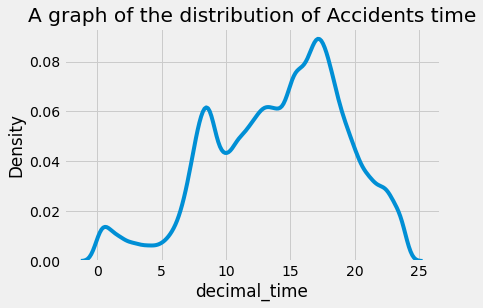

In [80]:
#Plot for decimal time
sns.kdeplot(data= Analysis, x ='decimal_time')
plt.title("A graph of the distribution of Accidents time")
plt.show()

The plot shows the data is not normal distributed and the rise in accident and within the ranges of sunrise and sunset respectively

In [81]:
# Create dataframes both for Sunrise range and the rest of the day
Sunrise = Analysis[(Analysis['decimal_time'] >4.45 )&(Analysis['decimal_time'] < 9.50)]
Rest_day = Analysis[(Analysis['decimal_time'] <= 4.45)|(Analysis['decimal_time'] >= 9.50)]


I was able to get sunrise time range in the year 2019 in the UK from ([sunrise and sunset.com][]). This formed the basis of what I performed frequentist statistics on, and created dataframes on.

The time is between 4:45 hour till 9:50 hour for sunrise.

[sunrise and sunset.com]: https://www.sunrise-and-sunset.com/en/sun/russia/uk/2019

In [82]:
Get_summary_stats_Numerical(Sunrise, ['decimal_time'])

column decimal_time has 302 Unique Values
8.500000    1604
8.000000    1459
9.000000    1352
7.500000    1095
8.750000    1044
8.833333    1018
8.333333     952
8.250000     905
7.833333     897
8.666667     853
Name: decimal_time, dtype: int64
 The mean of the frequency of decimal_time is : 139.98344370860926
modal value for decimal_time is 8.5
 The frequency for 8.5 is : 1604
The percentage of the modal score in the distribution is 3.794204612655234
count    42275.000000
mean         7.853513
std          1.101427
min          4.466667
25%          7.250000
50%          8.050000
75%          8.700000
max          9.483333
Name: decimal_time, dtype: float64
_________________________________________


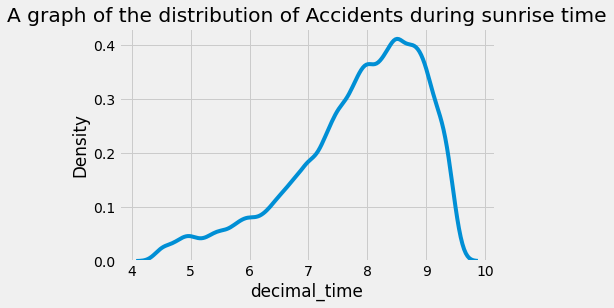

In [83]:
sns.kdeplot(data= Sunrise, x='decimal_time')
plt.title("A graph of the distribution of Accidents during sunrise time")
plt.show()

In [84]:
Get_summary_stats_Numerical(Rest_day, ['decimal_time'])

column decimal_time has 1137 Unique Values
17.0    2561
17.5    2221
16.5    2146
16.0    2062
18.0    2054
15.0    1939
15.5    1928
14.0    1787
18.5    1774
13.0    1697
Name: decimal_time, dtype: int64
 The mean of the frequency of decimal_time is : 189.89709762532982
modal value for decimal_time is 17.0
 The frequency for 17.0 is : 2561
The percentage of the modal score in the distribution is 1.1861258932996162
count    215913.000000
mean         15.362059
std           4.707023
min           0.016667
25%          12.750000
50%          15.916667
75%          18.416667
max          23.983333
Name: decimal_time, dtype: float64
_________________________________________


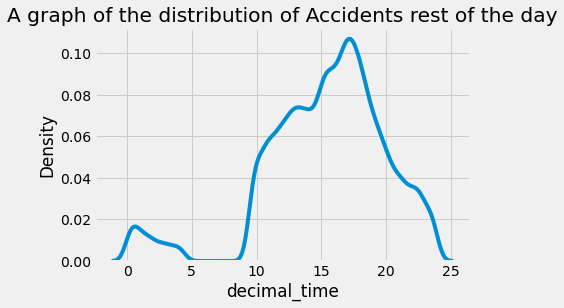

In [85]:
sns.kdeplot(data= Rest_day, x='decimal_time')
plt.title("A graph of the distribution of Accidents rest of the day")
plt.show()

The plots does not show normal distribution. Lets test with hypothesis testing method

In [86]:
#Check for normal distribution for Sunrise
Tests_numerical(Sunrise,'decimal_time','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [87]:
#Test for normal distribution for the rest of the day apart from Sunrise.
Tests_numerical(Rest_day,'decimal_time','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [88]:
#Test for effect of sunrise
Tests_numerical([Sunrise,Rest_day],'decimal_time','mannwhitneyu')

p-value for mannwhitneyu significance is:  0.0


'we reject null hypothesis for mannwhitneyu'

Comparing both dataframe's statistics, We first had the statistics which indicate the the frequency for the week with highest accident occurence is, and Using hypothesis testing to test both for the the shape of the data and confidence of the probability value of its randomness.


The frequency for the modal value for sunrise 1604 is 2561 against the frequency of the modal value for the rest of the day which is 2352

While the mean of their frequency is 139.98 and 189.89 respectively both for sunrise and the rest of the day.

These all confirms the decline in accidents frequency during Sunrise compared to the rest of the day.

The Use of Statistical tests

Shapiro test was used to test for shape while mannwhitneyu test was used to test for the confidence of the probability of it been random since it is not a Gaussian distributed data.

The P_value for Shapiro test is less than 0.05, this shows that the data is not Gaussian distributed


The P_value from mannwhitneyu test is less than 0.05, which means the Assumption that the that frequency of accident reduced during sunrise against other times of the day is true is true.

 Null value for all is rejected so effect is confirmed. Which means there is rise in traffic accident within the time range.

In [89]:
# Create Dataframe for sunset and the rest of the day
Sunset = Analysis[(Analysis['decimal_time'] >17.05 )&(Analysis['decimal_time'] < 22.05)]
Apart_from_set = Analysis[(Analysis['decimal_time'] <= 17.05)|(Analysis['decimal_time'] >= 22.05)]


I was able to get sunset time range in the year 2019 in the UK from ([sunrise and sunset.com][]). This formed the basis of what I performed frequentist statistics on, and dataframes were created

The time is between 17:05 hour till 22:05 hour for sunset respectively

[sunrise and sunset.com]: https://www.sunrise-and-sunset.com/en/sun/russia/uk/2019

In [90]:
Get_summary_stats_Numerical(Sunset, ['decimal_time'])

column decimal_time has 299 Unique Values
17.500000    2221
18.000000    2054
18.500000    1774
19.000000    1616
17.333333    1355
17.250000    1303
17.750000    1233
19.500000    1197
17.666667    1182
17.833333    1151
Name: decimal_time, dtype: int64
 The mean of the frequency of decimal_time is : 237.49832775919734
modal value for decimal_time is 17.5
 The frequency for 17.5 is : 2221
The percentage of the modal score in the distribution is 3.127640398805836
count    71012.000000
mean        19.031530
std          1.382120
min         17.066667
25%         17.833333
50%         18.750000
75%         20.050000
max         22.033333
Name: decimal_time, dtype: float64
_________________________________________


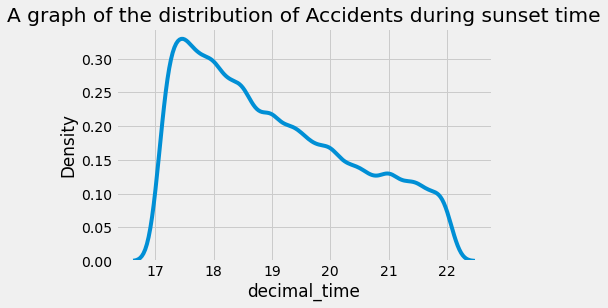

In [91]:
#Plot for distribution of sunset data range
sns.kdeplot(data= Sunset, x='decimal_time')
plt.title("A graph of the distribution of Accidents during sunset time")
plt.show()

In [92]:
Get_summary_stats_Numerical(Apart_from_set, ['decimal_time'])

column decimal_time has 1140 Unique Values
17.0    2561
16.5    2146
16.0    2062
15.0    1939
15.5    1928
14.0    1787
13.0    1697
8.5     1604
12.5    1587
13.5    1513
Name: decimal_time, dtype: int64
 The mean of the frequency of decimal_time is : 164.18947368421053
modal value for decimal_time is 17.0
 The frequency for 17.0 is : 2561
The percentage of the modal score in the distribution is 1.3682309697824506
count    187176.000000
mean         12.274054
std           4.816239
min           0.016667
25%           8.916667
50%          12.583333
75%          15.433333
max          23.983333
Name: decimal_time, dtype: float64
_________________________________________


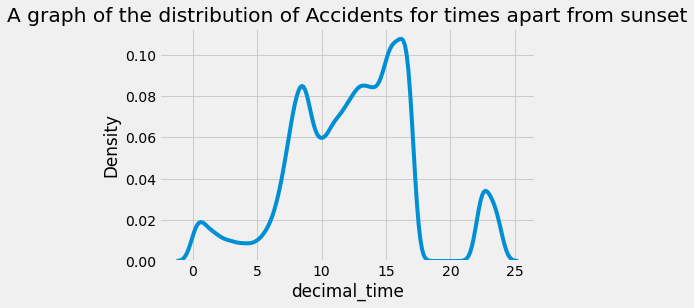

In [93]:
#Plot for the rest of the day apart from Sunset data range
sns.kdeplot(data= Apart_from_set, x='decimal_time')
plt.title("A graph of the distribution of Accidents for times apart from sunset")
plt.show()

Does not actually look gaussian distributed
Lets Use our hypothesis tests

In [94]:
#Test for Normal distribution for Sunset
Tests_numerical(Sunset,'decimal_time','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [95]:
#Test for normal distribution for the rest of the day apart from sunset
Tests_numerical(Apart_from_set,'decimal_time','shapiro')

p-value for significance is:  0.0


'we reject null hypothesis for shapiro'

In [96]:
#Test to compare both Sunset and Other times apart from sunset
Tests_numerical([Sunset,Apart_from_set],'decimal_time','mannwhitneyu')

p-value for mannwhitneyu significance is:  0.0


'we reject null hypothesis for mannwhitneyu'

Comparing both dataframe's statistics, We first had the statistics which indicate the the frequency for the week with highest accident occurence is, and Using hypothesis testing to test both for the the shape of the data and confidence of the probability value of its randomness.


The frequency for the modal value for sunset 2221 is 2561 against the frequency of the modal value for the rest of the day which is 2352

While the mean of their frequency is 237.498 and 164.189 respectively both for sunset and the rest of the day.

These all confirms the rise in accidents frequency during Sunset compared to the rest of the day.

The Use of Statistical tests

Shapiro test was used to test for shape while mannwhitneyu test was used to test for the confidence of the probability of it been random since it is not a Gaussian distributed data.

The P_value for Shapiro test is less than 0.05, this shows that the data is not Gaussian distributed


The P_value from mannwhitneyu test is less than 0.05, which means the Assumption that the that frequency of accident increased during sunset against other times of the day is true is true.

## Question F

**Question F :	Are there particular types of vehicles (engine capacity, age of vehicle, etc.) that are more frequently involved in road traffic accidents?**

Using visualization to check for frequency

We can see from the plot that vehicles that uses petrol are involved most in traffic accidents, This is due to its dominace as the most used vehicle among the populace

In [97]:
Get_summary_stats_Numerical(Analysis,['Age_of_Vehicle','Engine_Capacity_(CC)'])

column Age_of_Vehicle has 73 Unique Values
-1.0     63831
 1.0     25365
 8.0     21789
 3.0     13585
 4.0     13145
 2.0     12933
 5.0     12055
 6.0     10614
 12.0    10153
 7.0      9462
Name: Age_of_Vehicle, dtype: int64
 The mean of the frequency of Age_of_Vehicle is : 3536.821917808219
modal value for Age_of_Vehicle is -1.0
 The frequency for -1.0 is : 63831
The percentage of the modal score in the distribution is 24.722682696329805
count    258188.000000
mean          5.560661
std           5.941091
min          -1.000000
25%           1.000000
50%           5.000000
75%          10.000000
max          94.000000
Name: Age_of_Vehicle, dtype: float64
_________________________________________
column Engine_Capacity_(CC) has 996 Unique Values
-1.0       56294
 1248.0    15131
 1598.0    13977
 1318.0    12418
 1968.0     7961
 1995.0     7162
 998.0      6733
 1560.0     6351
 1242.0     5421
 1997.0     4333
Name: Engine_Capacity_(CC), dtype: int64
 The mean of the frequency of 

In [98]:
vehicle_stuffs = Analysis[['Age_of_Vehicle','Engine_Capacity_(CC)']]

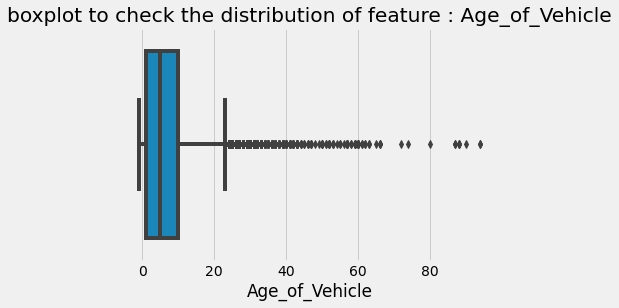

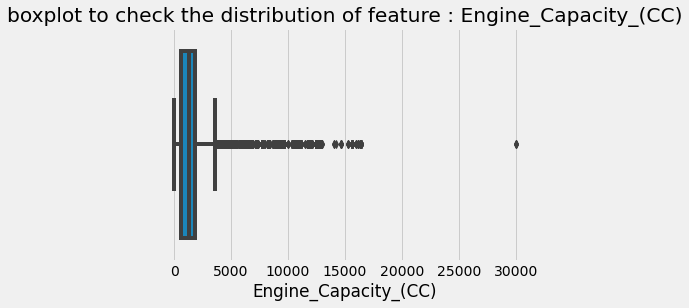

In [99]:
for i in vehicle_stuffs.columns:
    sns.boxplot(data=vehicle_stuffs, x=i)
    plt.title(f'boxplot to check the distribution of feature : {i}')
    plt.show()

The boxplot distribution shows the presence of outlier in the features. So we fix it

In [100]:

vehicle_stuffs['Age_of_Vehicle'] = Fix_outliers(vehicle_stuffs, 'Age_of_Vehicle', 'capping', 0.95, 0.05)

vehicle_stuffs['Age_of_Vehicle'] = Fix_outliers(vehicle_stuffs, 'Engine_Capacity_(CC)', 'capping', 0.95, 0.05)

0.946091466949734
0.4215644201411926
4.278525847732695
-0.09349130111792966


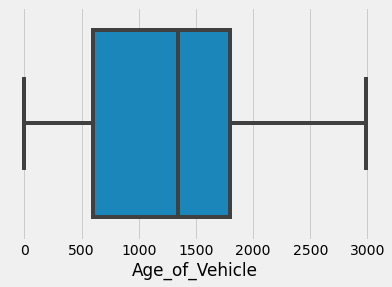

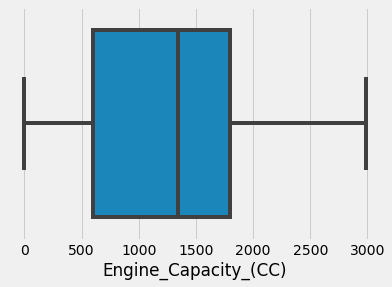

In [101]:
for i in vehicle_stuffs.columns:
    sns.boxplot(data=vehicle_stuffs, x=i)
    plt.show()

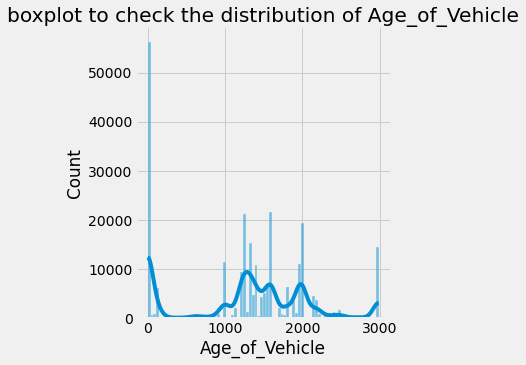

In [102]:
sns.displot(data= vehicle_stuffs, x='Age_of_Vehicle', kde= True)
plt.title(f'boxplot to check the distribution of Age_of_Vehicle')
plt.show()

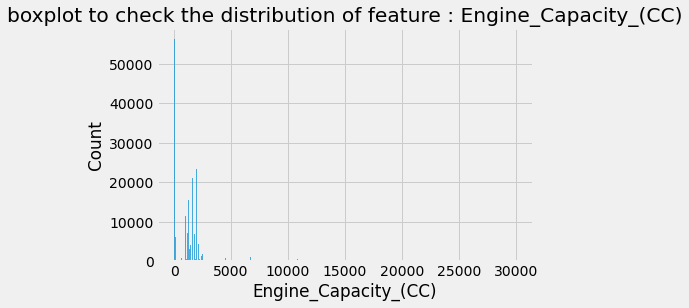

In [103]:
sns.histplot(data= Analysis, x='Engine_Capacity_(CC)')
plt.title(f'boxplot to check the distribution of feature : {i}')
plt.show()

The best way to treat Age_of_Vehicle and Engine_Capacity(CC) is to leave it as it is since the value -1 stands for unknown and Unknown has highest frequecies in both features

The frequency of -1 (unkown) for features Age_of_Vehicle and Engine_Capacity(CC) are 63831 and 56294 respectively.

Their frequency percentage from the whole distribution is 21.80% and 24.72% respectively.

This shows most of the vehicle involved in accidents don't have their data recorded for the features.

In [104]:
#Convert Labels to vehicles propulsion names
propulsion = {1:'Petrol',2:'Heavy',3:'Electric',4:'Steam',
             5:'Gas',6:'Petrol/Gas(LPG)',7:'Gas/Bi-fuel',
             8:'Hybrid electric',9:'Gas Diesel',
             10:'New fuel technology',11:'Fuel cells',
             12:'Electric diesel','M':'Undefined',-1:'missing'}
Analysis['Propulsion_Code'] = Convert(Analysis,'Propulsion_Code', propulsion)

In [105]:
Get_summary_stats_category(Analysis, ['Propulsion_Code'])

modal value for Propulsion_Code is Petrol
Unique values for Propulsion_Code is ['missing' 'Petrol' 'Heavy' 'Hybrid electric' 'Electric' 'Gas'
 'Electric diesel' 'Gas/Bi-fuel' 'Petrol/Gas(LPG)' 'Gas Diesel']
The number of unique values for Propulsion_Code is 10
 The frequency for Petrol is : 117252
The percentage of the modal score in the distribution is 45.413419678683745


Petrol             117252
Heavy               79804
missing             55817
Hybrid electric      4730
Electric              338
Gas/Bi-fuel           131
Electric diesel        58
Gas                    43
Petrol/Gas(LPG)        14
Gas Diesel              1
Name: Propulsion_Code, dtype: int64

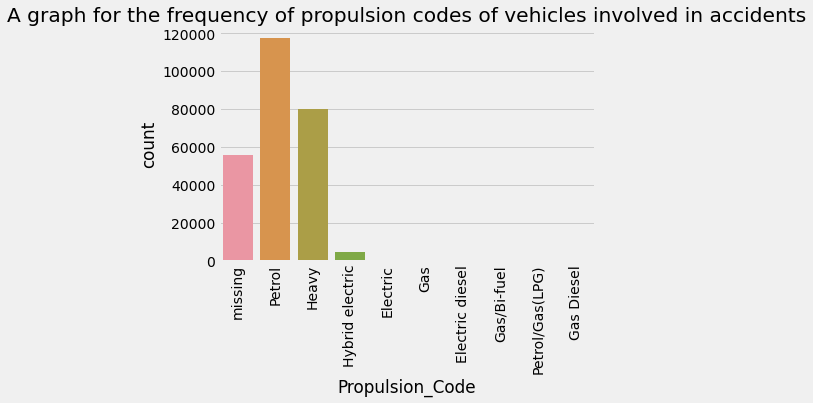

In [106]:
##plot the propulsion code and check modal score
sns.countplot(data= Analysis, x='Propulsion_Code')
plt.title("A graph for the frequency of propulsion codes of vehicles involved in accidents")
plt.tick_params(axis='x', rotation=90)
plt.show()

For propulsion code feature, Analysis carried out shows that :

The modal propulsion code is Petrol.

The frequency of Petrol propulsion code is 117252.

The percentage of Petrol propulsion code in the feature is 45.41%, This is nearly half of the total data.

For Age_of_Vehicle and Engine_Capacity_(CC) the non graphical EDA value count method shows -1, which stands for unknown is modal value of the distribution. while the modal value for Propulsion_Code is Petrol.

## Question G

**Question G Are there particular conditions (weather, geographic location, situations) that generate more road traffic accidents?**



In [107]:
# Convert feature values to weather conditions
weather = {1:'Fine no high winds',2:'Raining no high winds',3:'Snowing no high winds',4:'Fine + high winds',
             5:'Raining + high winds',6:'Snowing + high winds',7:'Fog or mist',
             8:'Other',9:'Unknown',
             -1:'missing'}
Analysis['Weather_Conditions'] = Convert(Analysis,'Weather_Conditions', weather)

In [108]:
Get_summary_stats_category(Analysis, ['Weather_Conditions'])

modal value for Weather_Conditions is Fine no high winds
Unique values for Weather_Conditions is ['Fine no high winds' 'Other' 'Raining no high winds' 'Unknown'
 'Fine + high winds' 'Snowing no high winds' 'Fog or mist'
 'Snowing + high winds' 'Raining + high winds']
The number of unique values for Weather_Conditions is 9
 The frequency for Fine no high winds is : 204972
The percentage of the modal score in the distribution is 79.3886625249818


Fine no high winds       204972
Raining no high winds     32970
Unknown                    6519
Other                      6261
Raining + high winds       2963
Fine + high winds          2851
Fog or mist                 799
Snowing no high winds       755
Snowing + high winds         98
Name: Weather_Conditions, dtype: int64

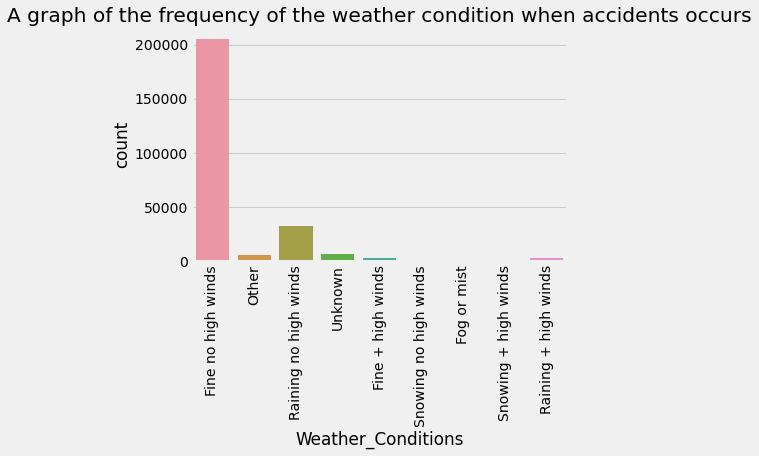

In [109]:
sns.countplot(data= Analysis, x='Weather_Conditions')
plt.tick_params(axis='x', rotation=90)
plt.title('A graph of the frequency of the weather condition when accidents occurs')
plt.show()

From the summary statistics we can deduce that :

The weather conditions with fine and no high winds has the modal frequency of accident occurence.

The frequency for the modal value is 204972.

The percentage of the modal score 79.389%.

It shows that bad weather conditions constitutes less to traffic accident occurence.

We can deduce from the weather feature distribution that traffic accidents happens most when the weather condition is fine and no high winds, followed by when it is raining with no high winds. This gives an intuition that people in the UK usually do not drive much when there is high winds, snow, fog, mist. That been the reason for low traffic accident frequency in those conditions

In [110]:
#Engineer Distance Feature from the Longitude and Latitude features using a spatial distance algorithm.
# I adopt cityblock(manhattan) algorithm because it deals with roads.
kilo = [] # Create an empty list
for i in range(len(Analysis)): # loop through the length of the dataframe rows
    dist = cityblock(Analysis['Longitude'][i],Analysis['Latitude'][i]) # Get the cityblock distance measures
    km = 6371*(math.pi/180)*dist # Convert the gotten distance to kilometre distance
    kilo.append(km) # Append it to the list created
Analysis['Kilometre'] = kilo # Use the list to create  a kilometre feature
Analysis['Kilometre'].describe()

count    258188.000000
mean       5996.193844
std         256.141677
min        5535.297348
25%        5757.083246
50%        6006.609165
75%        6162.217346
max        7234.163571
Name: Kilometre, dtype: float64

In [111]:
Get_summary_stats_Numerical(Analysis, ['Kilometre'])

column Kilometre has 116179 Unique Values
6185.488443    88
6200.288377    84
6057.316164    64
5787.502119    57
5708.494454    54
6081.030483    54
6231.179773    50
6135.797877    50
6213.617646    49
5755.622645    48
Name: Kilometre, dtype: int64
 The mean of the frequency of Kilometre is : 2.222329336627101
modal value for Kilometre is 6185.488443055033
 The frequency for 6185.488443055033 is : 88
The percentage of the modal score in the distribution is 0.034083690953878566
count    258188.000000
mean       5996.193844
std         256.141677
min        5535.297348
25%        5757.083246
50%        6006.609165
75%        6162.217346
max        7234.163571
Name: Kilometre, dtype: float64
_________________________________________


In [112]:
#Engineered feature scaled so that I get the difference of the location in kilometre closest to the null island 
#(point where the longitude and latitude is equals to zero) from other locations in Kilometre.
kilo_diff = Analysis['Kilometre'] - Analysis['Kilometre'].min() # Get the difference of kilometre by deducting the minimum value from other values
Analysis['kilo_diff'] = kilo_diff # Use the kilometre difference list to create a feature in Analysis dataframe
Analysis['kilo_diff'].describe()

count    258188.000000
mean        460.896496
std         256.141677
min           0.000000
25%         221.785898
50%         471.311817
75%         626.919999
max        1698.866223
Name: kilo_diff, dtype: float64

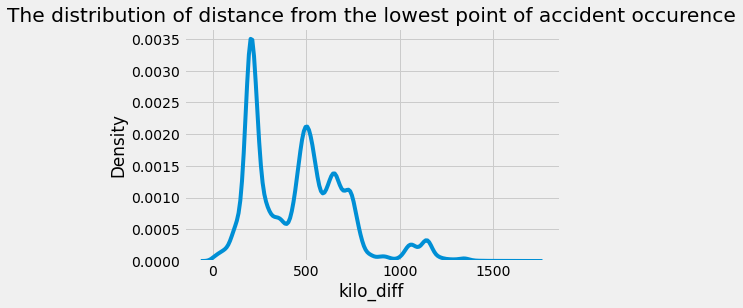

In [113]:
sns.kdeplot(data= Analysis, x= 'kilo_diff')
plt.title('The distribution of distance from the lowest point of accident occurence')
plt.show()

In [114]:
Get_summary_stats_Numerical(Analysis, ['kilo_diff'])

column kilo_diff has 116179 Unique Values
650.191095    88
664.991029    84
522.018816    64
252.204771    57
173.197107    54
545.733136    54
695.882425    50
600.500529    50
678.320298    49
220.325297    48
Name: kilo_diff, dtype: int64
 The mean of the frequency of kilo_diff is : 2.222329336627101
modal value for kilo_diff is 650.191095323069
 The frequency for 650.191095323069 is : 88
The percentage of the modal score in the distribution is 0.034083690953878566
count    258188.000000
mean        460.896496
std         256.141677
min           0.000000
25%         221.785898
50%         471.311817
75%         626.919999
max        1698.866223
Name: kilo_diff, dtype: float64
_________________________________________


Summary statistics shows that there are higher frequencies between 173 to 252 and 522 to 695 kilometer difference from the lowest kilometer value.

The kilometer with the highest accident occurence in the year 2019 is around 650 kilometer difference from the lowest kilometer, this accounts for over 88 accident occurence for the whole year.

That accounts for 0.034 % of the whole accident occurence through the year.


In [115]:
#Getting the dataframe of the distance(Kilometre) with top 10 values with highest frequencies
modal_loc = Analysis[(Analysis['kilo_diff']>173) & (Analysis['kilo_diff']<=252) | (Analysis['kilo_diff']>522) & (Analysis['kilo_diff']<=695)]

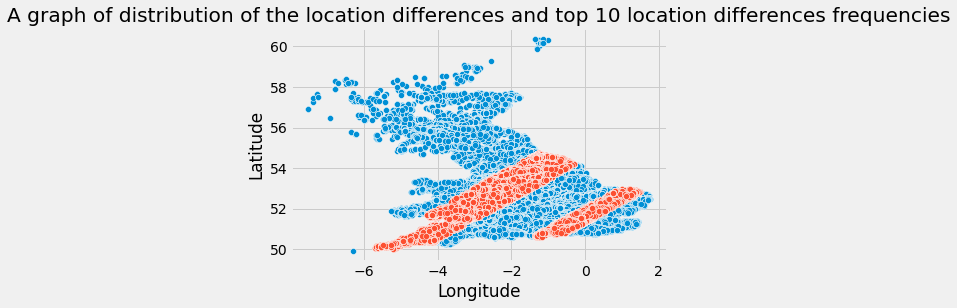

In [116]:
#Using plot to check for its distribution
sns.scatterplot(data= Analysis, x = 'Longitude', y = 'Latitude')
sns.scatterplot(data= modal_loc, x = 'Longitude', y = 'Latitude')
plt.title('A graph of distribution of the location differences and top 10 location differences frequencies')
plt.show()

The plot combine the graph for kilometer difference and longitude and latitude for total accident represented with blue color and top10 accident frequencies with red color. 

That puts the top10 accident frequencies in two clusters represented in red

In [117]:
# Assign the kilometer difference feature to a variable
P = Analysis[['kilo_diff']]

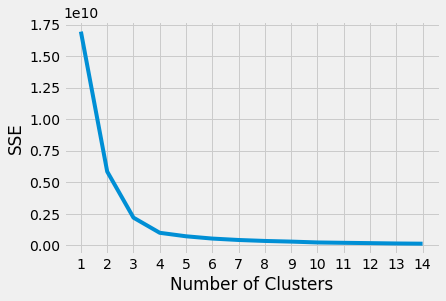

In [118]:
# Use elbow method to determine the optimal number of clusters for Kmeans clustering
Elbow_method(P,15,'random', 10, 300, 42)

In [119]:
#Use Kmeans clustering to engineer a new feature using its inertia_label as values
Analysis['kilo_clust'] = Cluster(P, 'random',3,10, 300, 42 )

kilo_diff    0
dtype: int64


In [120]:
Get_summary_stats_category(Analysis, ['kilo_clust'])

modal value for kilo_clust is 0
Unique values for kilo_clust is [1 0 2]
The number of unique values for kilo_clust is 3
 The frequency for 0 is : 130157
The percentage of the modal score in the distribution is 50.411715494136054


0    130157
1    112306
2     15725
Name: kilo_clust, dtype: int64

Cluster 2 takes the modal class with frequencies of 130157, taking 50.41% of the population 

While cluster 2 is the class with least frequencies with frequency of 15725

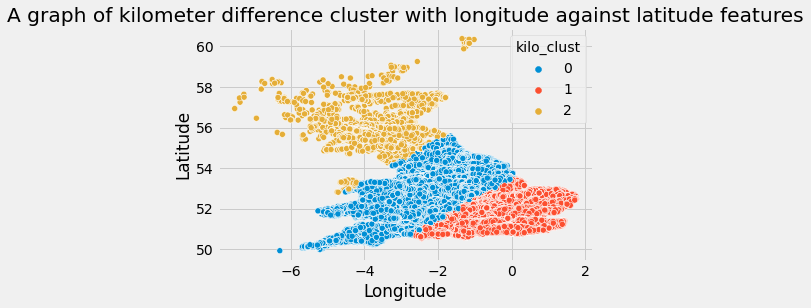

In [121]:
# plot the kilometer difference cluster with the longitude against latitude features
Analysis['kilo_clust'] = Analysis['kilo_clust'].astype('category') # Convert the kilometer difference to category datatype
sns.scatterplot(data= Analysis, x='Longitude',y='Latitude', hue='kilo_clust') # Plot the graph
plt.title('A graph of kilometer difference cluster with longitude against latitude features')
plt.show()

In [122]:
modal_loc = Analysis[(Analysis['kilo_diff']>173) & (Analysis['kilo_diff']<=252) | (Analysis['kilo_diff']>522) & (Analysis['kilo_diff']<=695)]

In [123]:
modal_loc['kilo_clust'].value_counts()

1    65380
0    57533
2        0
Name: kilo_clust, dtype: int64

The cluster for top10 frequency is shared between clusters 0 and 1 with cluster 1 having a little higher frequency than cluster 0.

In [124]:
# Convert Road_Type feature values to road type names
road = {1:'Roundabout',2:'One way street',3:'Dual carriage',6:'Single carriageway',7:'Slip road',
           9:'Unknown',12:'One way street/Slip road',
             -1:'missing'}
Analysis['Road_Type'] = Convert(Analysis,'Road_Type', road)

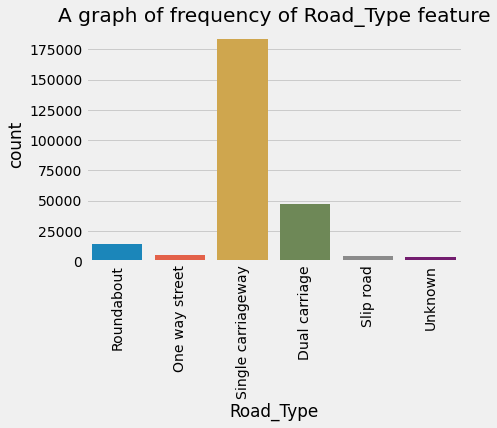

In [125]:
sns.countplot(data= Analysis, x='Road_Type')
plt.tick_params(axis='x', rotation=90)
plt.title('A graph of frequency of Road_Type feature')
plt.show()

In [126]:
Get_summary_stats_category(Analysis, ['Road_Type'])

modal value for Road_Type is Single carriageway
Unique values for Road_Type is ['Roundabout' 'One way street' 'Single carriageway' 'Dual carriage'
 'Slip road' 'Unknown']
The number of unique values for Road_Type is 6
 The frequency for Single carriageway is : 183524
The percentage of the modal score in the distribution is 71.08153748431376


Single carriageway    183524
Dual carriage          47343
Roundabout             14211
One way street          4927
Slip road               4352
Unknown                 3831
Name: Road_Type, dtype: int64

From the summary statistics we can deduce that :

The road type class Single carriageway has the modal frequency of accident occurence.

The frequency for the modal value is 183524.

The percentage of the modal score is 71.08%.

Single Carriage way seems to be the road type with most occurence, And that is expected since there is no demacation between vehicles moving towards opposite directions. So in hours with heavy traffic, accidents are bound to happen.

In [127]:
# Convert light_Conditions values to light conditions names
light = {1:'Daylight',4:'Darkness-lights lit',5:'Darkness - light unlit',6:'Darkness - no lighting',
        7:'Darkness - lighting unknown',
             -1:'missing'}
Analysis['Light_Conditions'] = Convert(Analysis,'Light_Conditions', light)

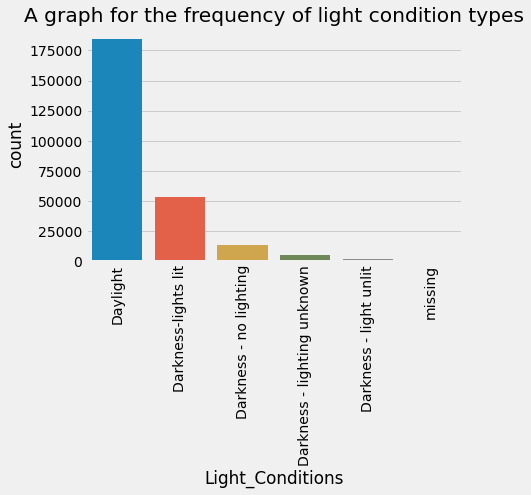

In [128]:
#Plot light conditions distribution
sns.countplot(data= Analysis, x='Light_Conditions')
plt.tick_params(axis='x', rotation=90)
plt.title('A graph for the frequency of light condition types')
plt.show()

In [129]:
Get_summary_stats_category(Analysis, ['Light_Conditions'])

modal value for Light_Conditions is Daylight
Unique values for Light_Conditions is ['Daylight' 'Darkness-lights lit' 'Darkness - no lighting'
 'Darkness - lighting unknown' 'Darkness - light unlit' 'missing']
The number of unique values for Light_Conditions is 6
 The frequency for Daylight is : 184426
The percentage of the modal score in the distribution is 71.43089531659102


Daylight                       184426
Darkness-lights lit             53007
Darkness - no lighting          13747
Darkness - lighting unknown      5211
Darkness - light unlit           1796
missing                             1
Name: Light_Conditions, dtype: int64

From the summary statistics we can deduce that :

The light condition class Daylight has the modal frequency of accident occurence.

The frequency for the modal value is 184426.

The percentage of the modal score is 71.43%.

This shows that accidents happens most during the day(Daylight), Though this is expected due to high tendency of heavy traffic during the day.

In [130]:
#Convert Road_Surface_Conditions feature values to Road_Surface_Conditions names
surface = {1:'Dry',2:'Wet or damp',3:'Snow',4:'Frost or ice',5:'Flood over 3cm. deep',
           6:'Oil or diesel',7:'Mud',
             -1:'missing'}
Analysis['Road_Surface_Conditions'] = Convert(Analysis,'Road_Surface_Conditions', surface)

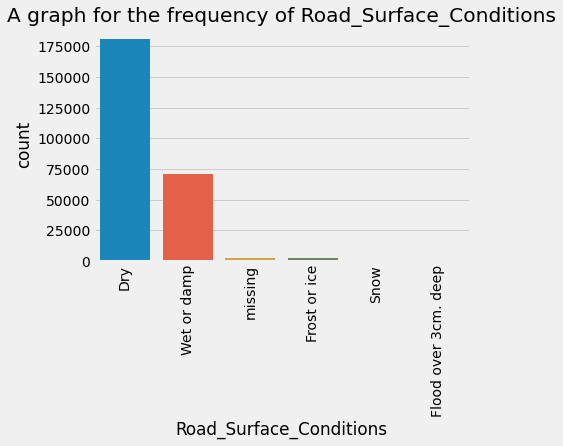

In [131]:
#Plot for frequencies of road surface conditions
sns.countplot(data= Analysis, x='Road_Surface_Conditions')
plt.title('A graph for the frequency of Road_Surface_Conditions')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [132]:
Get_summary_stats_category(Analysis, ['Road_Surface_Conditions'])

modal value for Road_Surface_Conditions is Dry
Unique values for Road_Surface_Conditions is ['Dry' 'Wet or damp' 'missing' 'Frost or ice' 'Snow'
 'Flood over 3cm. deep']
The number of unique values for Road_Surface_Conditions is 6
 The frequency for Dry is : 181126
The percentage of the modal score in the distribution is 70.15275690582057


Dry                     181126
Wet or damp              71253
missing                   2474
Frost or ice              2470
Snow                       512
Flood over 3cm. deep       353
Name: Road_Surface_Conditions, dtype: int64

From the summary statistics we can deduce that :

The road surface condition class Dry has the modal frequency of accident occurence.

The frequency for the modal value is 181126.

The percentage of the modal score is 70.15%.

The modal surface condition here is Dry, Which implies more traffic when the road is dry.

In [133]:
#Convert values in special conditions on site to special conditions names
special = {0:'None',1:'Auto traffic signal-out',2:'Auto signal part defective',3:'Road sign or marking defective or obscured',4:'Roadworks',5:'Road surface defective',
           6:'Oil or diesel',7:'Mud',
             -1:'missing'}
Analysis['Special_Conditions_at_Site'] = Convert(Analysis,'Special_Conditions_at_Site', special)

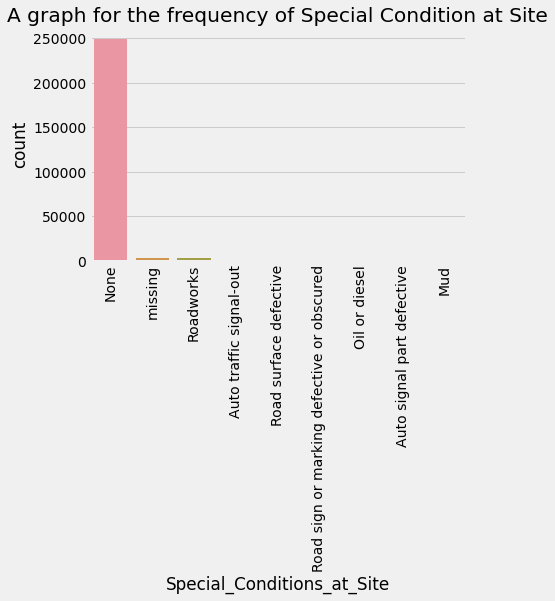

In [134]:
#Plotting Special_Condition_at_Site
sns.countplot(data= Analysis, x='Special_Conditions_at_Site')
plt.title('A graph for the frequency of Special Condition at Site')
plt.tick_params(axis='x', rotation=90)
plt.show()

In [135]:
Get_summary_stats_category(Analysis, ['Special_Conditions_at_Site'])

modal value for Special_Conditions_at_Site is None
Unique values for Special_Conditions_at_Site is ['None' 'missing' 'Roadworks' 'Auto traffic signal-out'
 'Road surface defective' 'Road sign or marking defective or obscured'
 'Oil or diesel' 'Auto signal part defective' 'Mud']
The number of unique values for Special_Conditions_at_Site is 9
 The frequency for None is : 249164
The percentage of the modal score in the distribution is 96.50487241854773


None                                          249164
missing                                         3287
Roadworks                                       3161
Auto traffic signal-out                          680
Mud                                              558
Road sign or marking defective or obscured       478
Oil or diesel                                    399
Road surface defective                           371
Auto signal part defective                        90
Name: Special_Conditions_at_Site, dtype: int64

From the summary statistics we can deduce that :

The Special Conditions at site class None has the modal frequency of accident occurence.

The frequency for the modal value is 249164.

The percentage of the modal score is 96.50%.

The modal class is when there is no special condition on the road. This implies that according to this data accidents are caused more by traffic than the present road condition 

## Question H

**Question H : How does driver related variables affect the outcome (e.g., age of the driver, and the purpose of the journey)?**



In [136]:
#Convert values for casualty Severity to Casualty_Severity names
severity = {1:'Fatal',2:'Serious',3:'Slight'}
Analysis['Casualty_Severity'] = Convert(Analysis,'Casualty_Severity', severity)

In [49]:
bins = [-1,0,19,40,101]
labels = ['missing','adolescence','youth','old']
Analysis['Age_Bin_of_Driver'] = pd.cut(Analysis['Age_of_Driver'], bins=bins, labels=labels, include_lowest=True)

In [50]:
Association = Join_two_dummied(Analysis,['Casualty_Severity','Age_Bin_of_Driver'],['Severity','Driver'],['sev','drv'],'sev_drv')

In [51]:
Apriori_association(Association, 0.2, 0.5, 'lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Driver_youth),(Severity_3.0),0.436608,0.847878,0.371078,0.849912,1.002398,0.000888,1.013548
1,(Severity_3.0),(Driver_youth),0.847878,0.436608,0.371078,0.437655,1.002398,0.000888,1.001862
2,(Driver_old),(Severity_3.0),0.402366,0.847878,0.336092,0.835291,0.985154,-0.005065,0.923576
3,(Severity_3.0),(Driver_old),0.847878,0.402366,0.336092,0.396392,0.985154,-0.005065,0.990104


Four associations can be seen from the analysis with high support and confidence, That of youth driver and severity 3.0 and old driver with severity 3.0

In [45]:
Purpose = {1:'Journey as part of work',2:'Commuting to/from work',3:'Taking pupil to/from school',4:'Pupil riding to/from school',5:'Other',
           6:'Not known',7:'Other/Not known (2005-10)',
             -1:'Data missing or out of range'}
Analysis['Journey_Purpose_of_Driver'] = Convert(Analysis,'Journey_Purpose_of_Driver',Purpose)

In [216]:
Journey_casualty = Join_two_dummied(Analysis, ['Journey_Purpose_of_Driver','Casualty_Severity'],['purpose','severity'],
                                    ['pur','sev'],'pur_sev')

In [218]:
Apriori_association(Journey_casualty,0.2,0.5,'lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(purpose_Not known),(severity_Slight),0.549712,0.847878,0.469886,0.854787,1.008148,0.003798,1.047573
1,(severity_Slight),(purpose_Not known),0.847878,0.549712,0.469886,0.554191,1.008148,0.003798,1.010047


The only associated classes are that of unknown journey purpose and slight casualty severity. 

This should be due to the fact that they both made up most of their respective features which constitutes to their 

# Model Building

I am going to build four different models, Two classification models for Location classes and severity and Two regression models for Location points and time.

First step is to create dataframes of relevant features for the different models

In [141]:
# Update dataframe
df['decimal_time'] = Analysis['decimal_time']
df['kilo_diff'] = Analysis['kilo_diff']
df['kilo_clust'] = Analysis['kilo_clust']
df['Hour'] = Analysis['Hour']
df['week'] = Analysis['week']

In [142]:
#Check df
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258188 entries, 0 to 258187
Data columns (total 74 columns):
 #   Column                                       Non-Null Count   Dtype   
---  ------                                       --------------   -----   
 0   Accident_Index                               258188 non-null  object  
 1   Location_Easting_OSGR                        258188 non-null  float64 
 2   Location_Northing_OSGR                       258188 non-null  float64 
 3   Longitude                                    258188 non-null  float64 
 4   Latitude                                     258188 non-null  float64 
 5   Police_Force                                 258188 non-null  int64   
 6   Accident_Severity                            258188 non-null  int64   
 7   Number_of_Vehicles                           258188 non-null  int64   
 8   Number_of_Casualties                         258188 non-null  int64   
 9   Date                                         258

In [143]:
#Classification Datasets
Location_class = df[['Location_Easting_OSGR','Location_Northing_OSGR','Road_Surface_Conditions','Road_Type',
                   'Urban_or_Rural_Area','kilo_clust']]
Severity = df[['Speed_limit','Weather_Conditions','Age_of_Casualty','Sex_of_Casualty','Age_of_Driver','Casualty_Class',
              'Journey_Purpose_of_Driver','Casualty_Type','Propulsion_Code','Casualty_Severity']]

In [144]:
# Regression Datasets
Location_point = df[['Location_Easting_OSGR','Location_Northing_OSGR','Road_Surface_Conditions','Road_Type',
                   'Urban_or_Rural_Area',"kilo_diff"]]
Time = df[['Weather_Conditions','week','Hour','Day_of_Week','Light_Conditions','Special_Conditions_at_Site','decimal_time']]

# Classification Models

#### Build Location class model
First classification model to build is Location class model

In [145]:
#Check dataset
Location_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258188 entries, 0 to 258187
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Location_Easting_OSGR    258188 non-null  float64 
 1   Location_Northing_OSGR   258188 non-null  float64 
 2   Road_Surface_Conditions  258188 non-null  int64   
 3   Road_Type                258188 non-null  int64   
 4   Urban_or_Rural_Area      258188 non-null  int64   
 5   kilo_clust               258188 non-null  category
dtypes: category(1), float64(2), int64(3)
memory usage: 20.1 MB


In [146]:
#Encode Categorical Features
Location_class_enc = lets_encode(Location_class,Location_class.columns, "le",LabelEncoder())

In [147]:
# Check for feature Importance
Loc_class_pos = Location_class_enc[(Location_class_enc['Location_Easting_OSGR']>=0)&(Location_class_enc['Location_Northing_OSGR']>=0)&(Location_class_enc['Road_Surface_Conditions']>=0)&(Location_class_enc['Road_Type']>=0)&(Location_class_enc['Urban_or_Rural_Area']>=0)&(Location_class_enc['kilo_clust']>=0)]
Loc_class_cols = ['Location_Easting_OSGR','Location_Northing_OSGR','Road_Surface_Conditions','Road_Type','Urban_or_Rural_Area','kilo_clust']
target_loc = 'kilo_clust'
Kbest_select(Loc_class_pos, Loc_class_cols, target_loc, chi2, 'all')

,features,scores
0,Location_Easting_OSGR,2.456298e+09
1,Location_Northing_OSGR,1.897064e+09
2,Road_Surface_Conditions,4.086186e+02
3,Road_Type,5.086297e+00
4,Urban_or_Rural_Area,1.710183e+03


In [148]:
# Engineer Features using PCA
loc_class_X = Location_class_enc.drop('kilo_clust',axis=1)
loc_class_y = Location_class_enc['kilo_clust']
loc_class_data = Scaler(loc_class_X, loc_class_X.columns, 'rbs')
principalDf_loc = PrincipalCA(loc_class_data, 3, ['col1','col2','col3'])

In [149]:
# Split data using train test split
loc_X_train,loc_X_test,loc_y_train,loc_y_test = Class_train_test_split(principalDf_loc, loc_class_y, 42, 0.25, loc_class_y, ['loc_X_train','loc_X_test','loc_y_train','loc_y_test'])

(193641, 3)
(64547, 3)
(193641,)
(64547,)


In [150]:
# Build and evaluate classification model
model_classifier(loc_X_train,loc_y_train,loc_X_test,loc_y_test,['Log','KNC','RanC','GbC'],
                 ['Log_pred','KNC_pred','RanC_pred','GbC_pred'])

Accuracy score for LogisticRegession is :0.9646923946891413
F1_score score for LogisticRegession is :0.9646954195025811
Accuracy score for LogisticRegession is :[[31514   785   240]
 [ 1005 27072     0]
 [  249     0  3682]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     32539
           1       0.97      0.96      0.97     28077
           2       0.94      0.94      0.94      3931

    accuracy                           0.96     64547
   macro avg       0.96      0.96      0.96     64547
weighted avg       0.96      0.96      0.96     64547

_________________________________________________________
Accuracy score for KNeighboursClassifier is :0.9979549785427673
F1_score score for KNeighboursClassifier is :0.9979531230043883
Confusion Matrix for KNeighboursClassifier is :[[32488    30    21]
 [   28 28049     0]
 [   53     0  3878]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.0

In [ ]:
Stacking_class([loc_X_train,loc_X_test],[loc_y_train,loc_y_test,],
                    [LogisticRegression(),KNeighborsClassifier(),RandomForestClassifier(),GradientBoostingClassifier()],
                   KNeighborsClassifier(),5,'predict',accuracy_score)

In [151]:
Cross_val_classifier(principalDf_loc,loc_class_y,5,1,['Log','KNC','RanC','GbC'])

scores for LogisticRegression() is 0.9643864219472068
_________________________________________________________
scores for KNeighborsClassifier() is 0.9981873666094975
_________________________________________________________
scores for RandomForestClassifier() is 0.9995119832458199
_________________________________________________________
scores for GradientBoostingClassifier() is 0.9923660269099006
_________________________________________________________


Model seems to be accurate based on some evaluation metrics

**For Casualty_Severity**

In [152]:
Casualty_enc = lets_encode(Severity,Severity.columns, "le",LabelEncoder())

In [153]:
Casualty_enc_pos = Casualty_enc[(Casualty_enc >= 0)]

In [177]:
Casualty_class_cols = Casualty_enc_pos.columns
target_casualty = 'Casualty_Severity'
Kbest_casualty = Kbest_select(Casualty_enc_pos, Casualty_class_cols, target_casualty, chi2, 'all')

#sns.barplot(Kbest_casualty, x='features', y='scores')
#plt.show()

,features,scores
0,Speed_limit,1631.563193
1,Weather_Conditions,1143.180651
2,Age_of_Casualty,9072.877399
3,Sex_of_Casualty,149.337040
4,Age_of_Driver,5232.488899
5,Casualty_Class,612.094382
6,Journey_Purpose_of_Driver,62.230705
7,Casualty_Type,5747.254835
8,Propulsion_Code,214.622885


In [155]:
casualty_class_X = Casualty_enc.drop('Casualty_Severity',axis=1)
casualty_class_y = Casualty_enc['Casualty_Severity']
casualty_class_data = Scaler(casualty_class_X, casualty_class_X.columns, 'rbs')
principalDf_casualty = PrincipalCA(casualty_class_data, 3, ['col1','col2','col3'])

In [156]:
cas_X_train,cas_X_test,cas_y_train,cas_y_test = Class_train_test_split(principalDf_casualty, casualty_class_y, 42, 0.25, loc_class_y, ['cas_X_train','cas_X_test','cas_y_train','cas_y_test'])

(193641, 3)
(64547, 3)
(193641,)
(64547,)


In [157]:
model_classifier(cas_X_train,cas_y_train,cas_X_test,cas_y_test,['Log','KNC','RanC','GbC'],
                 ['Log_pred','KNC_pred','RanC_pred','GbC_pred'])

Accuracy score for LogisticRegession is :0.8480951864532821
F1_score score for LogisticRegession is :0.7783857136337058
Accuracy score for LogisticRegession is :[[    0     0   670]
 [    0     0  9135]
 [    0     0 54742]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       670
           1       0.00      0.00      0.00      9135
           2       0.85      1.00      0.92     54742

    accuracy                           0.85     64547
   macro avg       0.28      0.33      0.31     64547
weighted avg       0.72      0.85      0.78     64547

_________________________________________________________
Accuracy score for KNeighboursClassifier is :0.8280322865508855
F1_score score for KNeighboursClassifier is :0.7928983875727517
Confusion Matrix for KNeighboursClassifier is :[[   17   141   512]
 [   55  1094  7986]
 [   78  2328 52336]]
              precision    recall  f1-score   support

           0       0.11      0.03      0.0

In [223]:
Stacking_class([cas_X_train,cas_X_test],[cas_y_train,cas_y_test,],
                    [LogisticRegression(),KNeighborsClassifier(),RandomForestClassifier(),GradientBoostingClassifier()],
                   KNeighborsClassifier(),5,'predict',accuracy_score)

 <function accuracy_score at 0x000002C0100358B0> of scikit-learn stacking classifier: 0.8474754829813934


In [158]:
Cross_val_classifier(principalDf_casualty,casualty_class_y,5,1,['Log','KNC','RanC','GbC'])

scores for LogisticRegression() is 0.8478782902544315
_________________________________________________________
scores for KNeighborsClassifier() is 0.8277185641579561
_________________________________________________________
scores for RandomForestClassifier() is 0.8283537564213643
_________________________________________________________
scores for GradientBoostingClassifier() is 0.847711745111361
_________________________________________________________


Model not too accurate based on evaluation metrics results

# Regression Models

#### Location point.
time to use regression predict the location point and time of accident.

In [159]:
# Check data information
Location_point.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258188 entries, 0 to 258187
Data columns (total 6 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Location_Easting_OSGR    258188 non-null  float64
 1   Location_Northing_OSGR   258188 non-null  float64
 2   Road_Surface_Conditions  258188 non-null  int64  
 3   Road_Type                258188 non-null  int64  
 4   Urban_or_Rural_Area      258188 non-null  int64  
 5   kilo_diff                258188 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 21.9 MB


In [160]:
#Encode categorical data
Location_cols_enc = lets_encode(Location_point,Location_point.columns, "le",LabelEncoder())

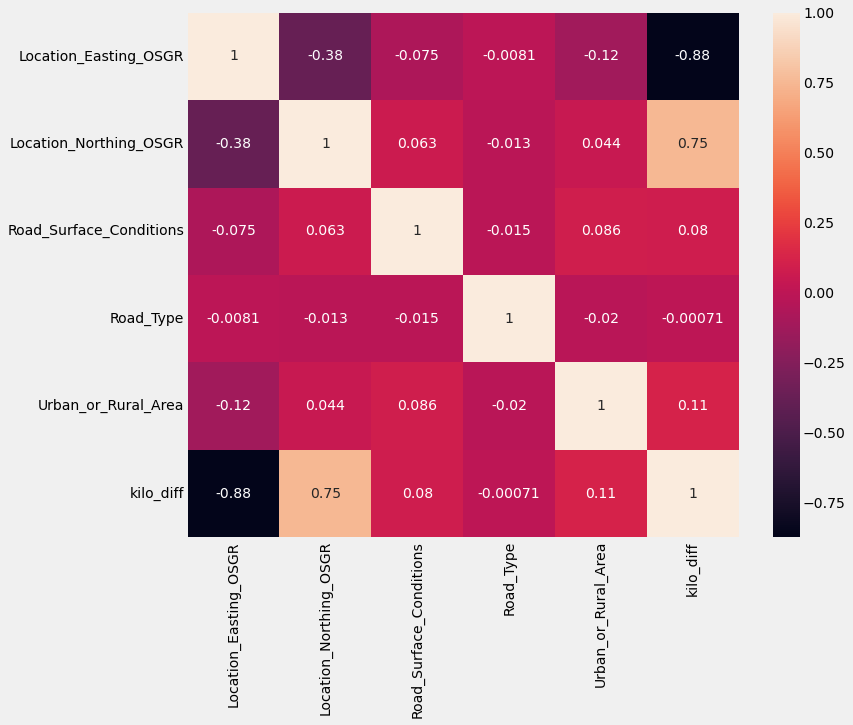

In [161]:
#Check for correlating features for feature importance
plt.subplots(figsize=(11, 9))
sns.heatmap(Location_cols_enc.corr(), annot= True)
plt.show()

In [162]:
# Engineer features using PCA
location_X = Location_cols_enc.drop('kilo_diff',axis=1)
location_y = Location_cols_enc['kilo_diff']
location_data = Scaler(location_X, location_X.columns, 'rbs')
principalDf_loc = PrincipalCA(location_data, 3, ['col1','col2','col3'])

In [163]:
# Split data using train_test_split
locp_X_train,locp_X_test,locp_y_train,locp_y_test = Reg_train_test_split(principalDf_loc, location_y, 42, 0.25,['locp_X_train','locp_X_test','locp_y_train','locp_y_test'])

(193641, 3)
(64547, 3)
(193641,)
(64547,)


In [164]:
#Build a regression model
models_regression(locp_X_train,locp_y_train,locp_X_test,locp_y_test,['Lin','KNR','RanR','GbR'],
                 ['Lin_pred','KNR_pred','RanR_pred','GbR_pred'])

RMSE score for LinearRegession is :7409.825593271751
r2_score score for LinearRegession is :0.9475929661899867
_________________________________________________________
RMSE score for KNeighborsRegressor is :853.6385749823575
r2_score score for KNeighboursRegressor is :0.9993044607030905
_________________________________________________________
RMSE score for RandomForestRegressor is :537.5709333361889
r2_score score for RandomForestRegressor is :0.9997241676724546
_________________________________________________________
RMSE score for GradientBoostingRegressor is :4924.041376533459
r2_score score for GradientBoostingRegressor is :0.976857141767685
_________________________________________________________


In [ ]:
Stacking_regr([locp_X_train,locp_X_test],[locp_y_train,locp_y_test,],
                    [LinearRegression(),KNeighborsRegressor(),RandomForestRegressor(),GradientBoostingRegressor()],
                   KNeighborsRegressor(),5,r2_score)

In [167]:
Cross_val_regression(principalDf_loc, location_y, 5, 1,['Lin','KNR','RanR','GbR'])

scores for LinearRegression() is 0.9479364772438572
_________________________________________________________
scores for KNeighborsRegressor() is 0.9993057952961883
_________________________________________________________
scores for RandomForestRegressor() is 0.999700111078061
_________________________________________________________
scores for GradientBoostingRegressor() is 0.9773514852691294
_________________________________________________________


The r2_score and RMSE shows that the model is accurate

**For Time**
A regression model to build

In [168]:
Time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258188 entries, 0 to 258187
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Weather_Conditions          258188 non-null  int64  
 1   week                        258188 non-null  float64
 2   Hour                        258188 non-null  int64  
 3   Day_of_Week                 258188 non-null  int64  
 4   Light_Conditions            258188 non-null  int64  
 5   Special_Conditions_at_Site  258188 non-null  int64  
 6   decimal_time                258188 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 23.8 MB


In [169]:
time_enc = lets_encode(Time,Time.columns, "le",LabelEncoder())

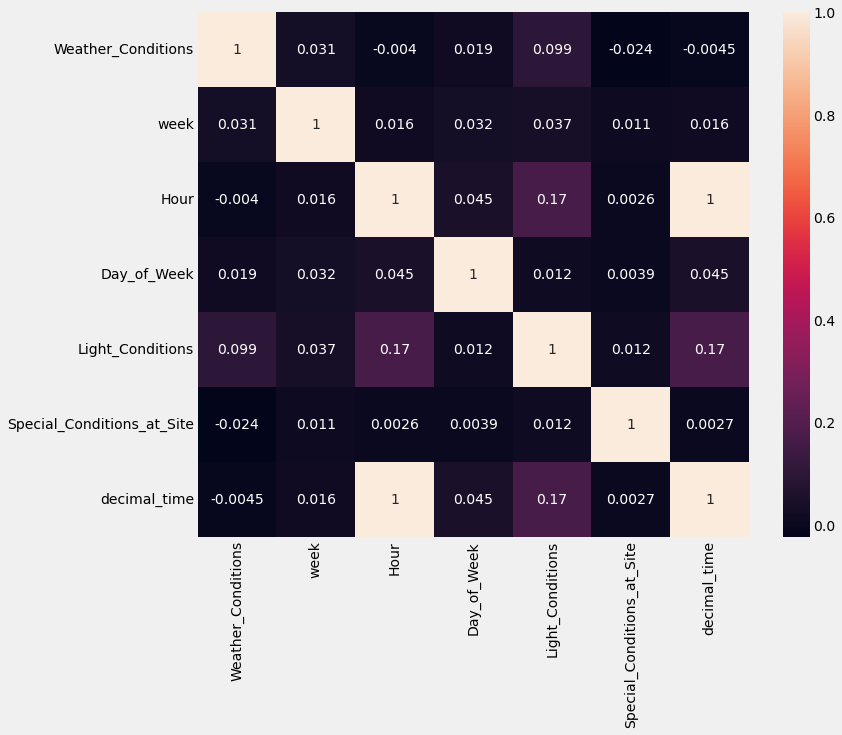

In [170]:
plt.subplots(figsize=(11, 9))
sns.heatmap(time_enc.corr(), annot= True)
plt.show()

In [171]:
time_X = time_enc.drop('decimal_time',axis=1)
time_y = time_enc['decimal_time']
time_data = Scaler(time_X, time_X.columns, 'rbs')
principalDf_time = PrincipalCA(time_data, 3, ['col1','col2','col3'])

In [172]:
time_X_train,time_X_test,time_y_train,time_y_test = Reg_train_test_split(principalDf_time, time_y, 42, 0.25,['time_X_train','time_X_test','time_y_train','time_y_test'])

(193641, 3)
(64547, 3)
(193641,)
(64547,)


In [173]:
models_regression(time_X_train,time_y_train,time_X_test,time_y_test,['Lin','KNR','RanR','GbR'],
                 ['Lin_pred','KNR_pred','RanR_pred','GbR_pred'])

RMSE score for LinearRegession is :21.420057353575874
r2_score score for LinearRegession is :0.9951900003915692
_________________________________________________________
RMSE score for KNeighborsRegressor is :17.84195247875468
r2_score score for KNeighboursRegressor is :0.9966627515582901
_________________________________________________________
RMSE score for RandomForestRegressor is :16.298783917505258
r2_score score for RandomForestRegressor is :0.9972150706221383
_________________________________________________________
RMSE score for GradientBoostingRegressor is :22.586703324186058
r2_score score for GradientBoostingRegressor is :0.9946517773710248
_________________________________________________________


In [ ]:
Stacking_regr([time_X_train,time_X_test],[time_y_train,time_y_test,],
                    [LinearRegression(),KNeighborsRegressor(),RandomForestRegressor(),GradientBoostingRegressor()],
                   KNeighborsRegressor(),5,r2_score)

In [174]:
Cross_val_regression(principalDf_time, time_y, 5, 1,['Lin','KNR','RanR','GbR'])

scores for LinearRegression() is 0.9951615637700529
_________________________________________________________
scores for KNeighborsRegressor() is 0.99638842505087
_________________________________________________________
scores for RandomForestRegressor() is 0.9972357976569375
_________________________________________________________
scores for GradientBoostingRegressor() is 0.9945973024751054
_________________________________________________________


# Recommendations

- Since we deduce from the hour and days of accident, It is recommended that more works should be placed on remote based so as to reduce traffic conjestions which in turn reduces traffic accidents.

- Analysis shows the dominance of petrol vehicle as the vehicle with most accidents, this shows the need of encouraging the masses to use alternative public transports like rail, big bus and so on.

- There should be policies which will help to effectively broadcast information about the stop of daylight savings.

- As much as possible single carriage ways should be dualized, this should reduce the accident occurence in locations.

- There should be demacations between passage ways for different road user, pedestrians ways should be different from taxi's, taxi's different from motorcycle and so on.